In [1]:
### RUN EVERY TIME: ECONOMIC INDICES RELEASES HISTORY EXTRACTING

In [2]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
import numpy as np
from datetime import date, datetime
from math import floor, ceil
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.x13 import x13_arima_analysis
from sklearn.decomposition import PCA
import os
import gc

%load_ext line_profiler

In [3]:
### RUN EVERY TIME: SEASONAL ADJUSTMENT MODULE PATHS SET UP

%env X13PATH = C:\Users\ighar\AppData\Roaming\jupyter\x13as
%env X12PATH = C:\Users\ighar\AppData\Roaming\jupyter\x13as
#%env

env: X13PATH=C:\Users\ighar\AppData\Roaming\jupyter\x13as
env: X12PATH=C:\Users\ighar\AppData\Roaming\jupyter\x13as


In [4]:
## VERSION CONTROL

from platform import python_version
print('pandas version: ', pd.__version__)
print('python version: ', python_version())

pandas version:  0.25.3
python version:  3.7.4


In [5]:
### RUN EVERY TIME: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable']
### Raw data path and sheets:
str_path_bb_idx_source = 'Data_Files/Source_Files/Bloomberg_Eco_Indices.xlsx'
str_us_sheet = 'US Eco Const'
str_all_sheet = 'All Eco Const'
### Flags data path and sheets:
str_path_bb_idx_flags = 'Data_Files/Source_Files/Bloomberg_Eco_Flags_Extended.xlsx'
str_flag_sheet = 'Bloomberg Description'
### Source data constants:
int_idx_cols = 12
### HDF file with converted source data:
str_path_bb_idx_hdf = 'Data_Files/Source_Files/Bloomberg_Eco_Indices.h5'
str_key_flags = 'flags_exported' ### Acadian flags list
str_key_exported = 'all_idx_exported' ### Raw export with only replacing zero dates and after 2021-01-01 dates with np.NaN
str_key_raw_filled = 'all_idx_raw_filled' ### Raw export with initial dates, dates gaps, absent date coluns filled
str_key_raw_history = 'raw_history' ### Export with all the corrections and fillings (restructured to [Index_Name -> Data_Date -> Observation_Date] | Index_Value series)
str_key_bday_history = 'bday_history' ### Raw history vector with observation dates moved to nearest future business dates
str_key_num_history = 'num_history' ### Bday history vector with observation dates changed to their date numbers (for future matrix cube saving as hdf file)
str_key_from_date = 'idx_from_date' ### Series to get date numbers from dates
str_key_to_date = 'idx_to_date' ### Series to get dates from date numbers
str_key_types_info = 'types_info' ### Dataframe with 'Type_Prime' / 'Sub_Type' / 'Region' groups descriptions
str_key_flags_typed = 'flags_typed' ### Dataframe with economic indices descriptions taking into account 
### HDF file with matrices:
str_path_bb_matrix_hdf = 'Data_Files/Source_Files/Matrix_Eco_Indices.h5'
str_key_matrix_z = 'matrix_cube_z_scored'
### HDF file with diagonals:
str_path_bb_diag_hdf = 'Data_Files/Source_Files/Diag_Eco_Indices.h5'
str_key_diag_daily_raw = 'matrix_diagonal_raw'
str_key_diag_daily_z = 'matrix_diagonal_z'
str_key_diag_group_z = 'groups_diagonal_z'
str_key_diag_sub_z = 'sub_types_diagonal_z'
str_key_diag_agg_z = 'aggregated_diagonal_z'
str_key_diag_mean_z = 'mean_diagonal_z'
### HDF file with group averages:
str_path_group_matrix_hdf = 'Data_Files/Source_Files/Matrix_Groups.h5'
str_key_group_matrix = 'matrix_cube_groups'
### HDF file with overall event dates as series index:
str_path_overall_dates_hdf = 'Data_Files/Source_Files/Overall_Dates.h5'
str_key_event_dates = 'overall_event_dates'
str_key_obs_dates = 'overall_obs_dates'
str_key_triangle_dates = 'overall_triangle_dates'
### HDF file with sub type averages:
str_path_sub_matrix_hdf = 'Data_Files/Source_Files/Matrix_Sub.h5'
str_key_sub_matrix = 'matrix_cube_subs'
### HDF file with global indices PCA FPC:
str_path_global_matrix_hdf = 'Data_Files/Source_Files/Matrix_Global.h5'
str_key_global_matrix = 'matrix_cube_globals'
### HDF file with global indices simple averages:
str_path_mean_matrix_hdf = 'Data_Files/Source_Files/Matrix_Mean.h5'
str_key_mean_matrix = 'matrix_cube_means'
### Observation axis range:
datetime_start = datetime(1984, 12, 31) # Start date for efficacy measures
date_start = datetime_start.date()
datetime_end = datetime(2020, 8, 31) # End date for efficacy measures
date_end = datetime_end.date()
idx_date_range = pd.date_range(date_start, date_end, freq = 'B')
datetime_basis = datetime(1993, 12, 31) # End date for efficacy measures
date_basis = datetime_basis.date()
### Gaps filling options:
int_revision_shift = 1
int_final_shift = 2
int_first_mean_length = 12
dict_final_only_lag = {}
dict_final_only_lag['Quarterly'] = 90 // 2
dict_final_only_lag['Monthly'] = 30 // 2
dict_final_only_lag['Other'] = 7 // 2
### Cumprod shifts for monthly data frequency:
dict_cumprod_step = {}
dict_cumprod_step['MoM%'] = 1
dict_cumprod_step['QoQ%'] = 3
dict_cumprod_step['YoY%'] = 12
### Stock-like series shifts for YoY transformation:
dict_yoy_shift = {}
dict_yoy_shift['Monthly'] = 12
dict_yoy_shift['Quarterly'] = 4
dict_yoy_shift['Other'] = 52
### Group tickers rebasing options:
int_not_to_rebase_term = 7 ### Term in years for min ticker data date when we do not need to rebase it with basis group ticker
int_not_to_rebase_diff = 2 ### Minimal difference in years between basis ticker and other group ticker min date when we need to rebase group ticker
### Z-scoring options:
int_winsorize_bound = 4
flo_winsorize_tolerance = 0.0001
int_winsorize_steps_limit = 5
### Diagonal options:
int_min_years = 3
date_diag_start = datetime(1994, 1, 1)
### Data filling limit
int_fill_limit = 20
### Regions weights:
dict_region_weight = {}
dict_region_weight['US'] = 0.50
dict_region_weight['Europe'] = 0.25
dict_region_weight['Japan'] = 0.15
dict_region_weight['UK'] = 0.10
### Groups aggregation order:
list_agg_groups = [['EMP'], ['INF'], ['ANT', 'CON', 'OUT']]
dict_agg_groups = {}
dict_agg_groups['Employment'] = ['EMP']
dict_agg_groups['Inflation'] = ['INF']
dict_agg_groups['Economy'] = ['ANT', 'CON', 'OUT']

In [6]:
### DEFINING OBSERVATION DATE VECTOR EXTRACTION

def get_obs_date_vector(str_ticker, str_date, bool_exact_date = False, bool_drop_levels = False):
    ### Vector for exact date:
    if bool_exact_date:
        ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
    ### Vector for nearest date:        
    else:
        ### Loading full ticker series:        
        ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
        ### Extracting data for max date less or equal to needed date:
        ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
    ### Dropping constant index levels if needed:
    if bool_drop_levels:
        return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
    else:
        return ser_obs_date

In [7]:
### DEFINING WEIGHTED AVERAGE FOR DATAFRAME COLUMNS (PART OF THE PRODUCT CODE)

def columns_average(df_series, list_weights = False): 
    ### Single column check
    if (len(df_series.columns) > 1):
        ### Equal weights list creating:
        if isinstance(list_weights, bool):
            list_weights = [1] * len(df_series.columns)
        ### Dataframe of weights initialising:
        df_weights = pd.DataFrame(np.NaN, index = df_series.index, columns = df_series.columns)
        for iter_num, iter_col in enumerate(df_weights.columns):
            df_weights[iter_col] = list_weights[iter_num]
        ### Zeroing weights for NaN values:
        for iter_col in df_weights.columns:
            df_weights.loc[df_series[iter_col].isna(), iter_col] = 0
        ser_mean = (df_series.multiply(df_weights).sum(axis = 1)).div(df_weights.sum(axis = 1))    
        ### Results output:
        del df_series
        del df_weights    
        gc.collect()
    else:
        ser_mean = df_series.squeeze()
        del df_series
        gc.collect()        
    return ser_mean

In [ ]:
### RUN TO RE-EXPORT DATA: SOURCE FILE EXPORT

### Reading excel file:
df_all_idx_raw = pd.read_excel(io = str_path_bb_idx_source, sheet_name = str_all_sheet, skiprows = [0], index_col = None, header = None, parse_dates = True,
                               na_values = list_na_excel_values, keep_default_na = False)
### List of dataframes for each eco index initializing:
list_idx_raw = []
### Extracting and converting each eco index data block seperately to proper form:
for int_iter_idx_col in range(len(df_all_idx_raw.columns) // int_idx_cols):
    ### Extracting raw data:
    df_iter_idx_raw = df_all_idx_raw.iloc[All, (int_iter_idx_col * int_idx_cols) : ((int_iter_idx_col + 1) * int_idx_cols) - 1]
    ### Assigning colum names:
    df_iter_idx_raw.columns = df_iter_idx_raw.iloc[1]
    df_iter_idx_raw.columns.name = ''    
    ### Dropping empty rows:
    df_iter_idx_raw.dropna(how = 'all', inplace = True)
    ### Extracting eco index name:
    df_iter_idx_raw['Index_Name'] = df_iter_idx_raw.iloc[0, 0]
    ### Dropping identification rows (no longer needed):
    df_iter_idx_raw.drop([0, 1], axis = 0, inplace = True)
    ### Setting multiindex:
    df_iter_idx_raw.set_index(['Date', 'Index_Name'], drop = True, append = False, inplace = True)
    ### ADding dataframe to list:
    list_idx_raw.append(df_iter_idx_raw)
### Exported data aggregating:
df_all_idx_exported = pd.concat(list_idx_raw, axis = 0).swaplevel()
### Exported data saving:
df_all_idx_exported.index.names = ['Index_Name', 'Data_Date']
### Types converting for numerical data:
df_all_idx_exported = df_all_idx_exported.astype({'PX_LAST': 'float',
                                                  'ACTUAL_RELEASE': 'float',
                                                  'FIRST_REVISION': 'float',
                                                  'BN_SURVEY_NUMBER_OBSERVATIONS': 'float',
                                                  'BN_SURVEY_MEDIAN': 'float',
                                                  'BN_SURVEY_AVERAGE': 'float',
                                                  'FORECAST_STANDARD_DEVIATION': 'float',
                                                 })
### Zero dates dropping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] == 0, ['ECO_RELEASE_DT']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] == 0, ['FIRST_REVISION_DATE']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] == 0, ['ECO_FUTURE_RELEASE_DATE']] = np.NaN
### Incorrect dates droppping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] > 20210000, 'ECO_RELEASE_DT'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] > 20210000, 'FIRST_REVISION_DATE'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] > 20210000, 'ECO_FUTURE_RELEASE_DATE'] = np.NaN
### Dates formatting:
df_all_idx_exported['ECO_RELEASE_DT'] = pd.to_datetime(df_all_idx_exported['ECO_RELEASE_DT'].astype(str), format = '%Y%m%d')
df_all_idx_exported['FIRST_REVISION_DATE'] = pd.to_datetime(df_all_idx_exported['FIRST_REVISION_DATE'].astype(str), format = '%Y%m%d')
df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] = pd.to_datetime(df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'].astype(str), format = '%Y%m%d')
### Exported dataframe saving:
df_all_idx_exported.to_hdf(str_path_bb_idx_hdf, key = str_key_exported, mode = 'w')

In [ ]:
### RUN TO RE-EXPORT DATA: FLAGS FILE EXPORT

### Reading excel file:
df_flags = pd.read_excel(io = str_path_bb_idx_flags, sheet_name = str_flag_sheet, usecols = list(range(38))[1: ], index_col = 0, skiprows = list(range(6)), header = 0,
                               parse_dates = True, na_values = list_na_excel_values, keep_default_na = False)
### Dataframe transforming:
df_flags.dropna(how = 'all', inplace = True)
df_flags.index.name = 'Index_Name'
### Choosing columns to go on with:
df_flags = \
        df_flags[['CTRY', 'Type', 'Category', 'Negative', 'Security Description', 'SA/NSA', 'Processing', 'Index: Base', 'Type 2', 'INDX_SOURCE', 'DES_NOTES', 'INDX_FREQ']]
### Columns renaming:
df_flags.columns = ['Region', 'Type_Prime', 'Category', 'Negative', 'Description', 'SA_Status', 'Processing', 'Base', 'Type_Second', 'Data_Source', 'Notes', 'Frequency']
### Seasonality Adjustment Flag filling:
df_flags['SA_Status'] = df_flags['SA_Status'].fillna('Unclear')
### Processing Index separating:
df_flags['Processing'] = df_flags['Processing'].str.partition(': ')[0].str.strip()
### Base filling:
df_flags['Base'] = df_flags['Base'].fillna(-1)
### Euro countries region renaming:
df_flags.loc[~df_flags['Region'].isin(['Japan', 'UK', 'US']), 'Region'] = 'Europe'
### Columns reordering:
df_flags = df_flags[['Type_Prime', 'Type_Second', 'Category', 'Region', 'Processing', 'Base', 'SA_Status', 'Frequency', 'Negative', 'Description', 'Data_Source', 'Notes']]
### Types converting:
df_flags = df_flags.astype({'Type_Prime': 'str',
                            'Type_Second': 'str',
                            'Category': 'str',
                            'Region': 'str',
                            'Processing': 'str',
                            'Base': 'int',
                            'SA_Status': 'str',
                            'Frequency': 'str',
                            'Negative': 'int',
                            'Description': 'str',
                            'Data_Source': 'str',
                            'Notes': 'str'})
### Exported dataframe saving:
df_flags.to_hdf(str_path_bb_idx_hdf, key = str_key_flags, mode = 'a')

In [ ]:
### RUN TO RE-EXPORT DATA: RELEASES AND REVISIONS DATA EXTRACTING

### Revisions data reading (99,180 rows):
df_all_idx_revisions = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_exported)[
                                   ['PX_LAST', 'ECO_RELEASE_DT', 'ACTUAL_RELEASE', 'FIRST_REVISION_DATE', 'FIRST_REVISION', 'ECO_FUTURE_RELEASE_DATE']]
### Dropping rows with all Index Values missed (96,369 rows left):
#df_all_idx_revisions = \
#        df_all_idx_revisions.loc[df_all_idx_revisions['PX_LAST'].notna() | df_all_idx_revisions['ACTUAL_RELEASE'].notna() | df_all_idx_revisions['FIRST_REVISION'].notna()]
### Date filtering:
df_all_idx_revisions = df_all_idx_revisions.reset_index('Data_Date')
df_all_idx_revisions = df_all_idx_revisions.loc[df_all_idx_revisions['Data_Date'] >= datetime_start].set_index('Data_Date', append = True)
### Columns renaming:
df_all_idx_revisions.columns = ['Final_Value', 'Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Future_Date']

In [ ]:
### RUN TO RE-EXPORT DATA: DATA REPAIRING

### 1 : MPMIITMA Index Revision_Value mistake correction:
df_all_idx_revisions.loc[('MPMIITMA Index', All), 'Revision_Value'] = np.NaN
### 2 : JNCPT Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNCPT Index', '1999-07-31'), 'Release_Date'] = pd.to_datetime('1999-07-30')
df_all_idx_revisions.loc[('JNCPT Index', '2001-01-31'), 'Release_Date'] = pd.to_datetime('2001-01-26')
df_all_idx_revisions.loc[('JNCPT Index', '2001-02-28'), 'Release_Date'] = pd.to_datetime('2001-03-02')
df_all_idx_revisions.loc[('JNCPT Index', '2001-06-30'), 'Release_Date'] = pd.to_datetime('2001-06-29')
### 3 : JNCSTOTY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNCSTOTY Index', '2018-12-31'), 'Release_Date'] = pd.to_datetime('2019-01-31')
### 4: JNPIY Index Revision_Date mistakes correction:
df_all_idx_revisions.loc[('JNPIY Index', '2015-12-31'), 'Revision_Date'] = pd.to_datetime('2016-02-23')
### 5: JNPIY Index Revision_Date mistakes correction:
df_all_idx_revisions.loc[('JNTIAIAM Index', '2017-11-30'), 'Revision_Date'] = pd.to_datetime('2018-02-20')
### 6: BECPCHNG Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('BECPCHNG Index', '1997-01-31'), 'Release_Date'] = pd.to_datetime('1997-01-30')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-10-31'), 'Release_Date'] = pd.to_datetime('2001-10-28')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-11-30'), 'Release_Date'] = pd.to_datetime('2001-11-29')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-12-31'), 'Release_Date'] = pd.to_datetime('2001-12-23')
### 7 : BEUER Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('BEUER Index', '1997-01-31'), 'Release_Date'] = pd.to_datetime('1997-02-06')
### 8 : FRCPEECM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('FRCPEECM Index', '1997-07-31'), 'Release_Date'] = pd.to_datetime('1997-08-14')
### 9 : FRCPIMOM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('FRCPIMOM Index', '1999-01-31'), 'Release_Date'] = pd.to_datetime('1999-02-24')
df_all_idx_revisions.loc[('FRCPIMOM Index', '1999-02-28'), 'Release_Date'] = pd.to_datetime('1999-03-24')
df_all_idx_revisions.loc[('FRCPIMOM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-02-21')
### 10 : GKCPNEWY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-03-31'), 'Release_Date'] = pd.to_datetime('2001-04-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-04-30'), 'Release_Date'] = pd.to_datetime('2001-05-10')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-05-31'), 'Release_Date'] = pd.to_datetime('2001-06-10')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-06-30'), 'Release_Date'] = pd.to_datetime('2001-07-05')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-07-31'), 'Release_Date'] = pd.to_datetime('2001-08-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-08-31'), 'Release_Date'] = pd.to_datetime('2001-09-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-09-30'), 'Release_Date'] = pd.to_datetime('2001-10-08')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-10-31'), 'Release_Date'] = pd.to_datetime('2001-11-08')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-11-30'), 'Release_Date'] = pd.to_datetime('2001-12-09')
### 11 : GKUERATE Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GKUERATE Index', '2007-01-31'), 'Release_Date'] = np.NaN
### 12 : GRCP2NRM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GRCP2NRM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-01-30')
### 13 : GRCP2SAM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GRCP2SAM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-01-30')
### 14 : ITVHYOY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('ITVHYOY Index', '1999-01-31'), 'Release_Date'] = pd.to_datetime('1999-02-03')
### 15 : JNLSUCTL Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNLSUCTL Index', '2003-01-31'), 'Release_Date'] = pd.to_datetime('2003-03-01')
### 16 : PTCIEC Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('PTCIEC Index', '2007-12-31'), 'Release_Date'] = pd.to_datetime('2008-01-08')
### 17 : SLCPLHMM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SLCPLHMM Index', '2004-04-30'), 'Release_Date'] = pd.to_datetime('2004-05-20')
df_all_idx_revisions.loc[('SLCPLHMM Index', '2005-01-31'), 'Release_Date'] = pd.to_datetime('2005-02-27')
df_all_idx_revisions.loc[('SLCPLHMM Index', '2005-02-28'), 'Release_Date'] = pd.to_datetime('2005-03-16')
### 18 : SPCPEUMM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-01-31'), 'Release_Date'] = pd.to_datetime('2000-02-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-02-29'), 'Release_Date'] = pd.to_datetime('2000-03-14')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-03-31'), 'Release_Date'] = pd.to_datetime('2000-04-11')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-04-30'), 'Release_Date'] = pd.to_datetime('2000-05-11')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-05-31'), 'Release_Date'] = pd.to_datetime('2000-06-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-06-30'), 'Release_Date'] = pd.to_datetime('2000-07-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-07-31'), 'Release_Date'] = pd.to_datetime('2000-08-14')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-08-31'), 'Release_Date'] = pd.to_datetime('2000-09-13')
### 19 : SPROCHNG Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SPROCHNG Index', '2008-01-31'), 'Release_Date'] = pd.to_datetime('2008-02-25')
### 20 : SVAWRYOY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SVAWRYOY Index', '2006-08-31'), 'Release_Date'] = pd.to_datetime('2006-10-15')
df_all_idx_revisions.loc[('SVAWRYOY Index', '2006-09-30'), 'Release_Date'] = pd.to_datetime('2006-11-15')
df_all_idx_revisions.loc[('SVAWRYOY Index', '2006-10-31'), 'Release_Date'] = pd.to_datetime('2006-12-17')
### 21 : INJCJC Index Data Date shifts correction:
df_all_idx_revisions.loc[('INJCJC Index', '2020-08-28'), 'Release_Date'] = np.NaN
str_ei_to_correct = 'INJCJC Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_to_correct = df_ei_to_correct.drop(df_ei_to_correct.loc[df_ei_to_correct.isna().all(axis = 1)].index)
df_ei_to_correct_shifted = df_ei_to_correct.shift(-1)
df_ei_to_correct_shifted.columns = [str_column_name + '_shifted' for str_column_name in df_ei_to_correct_shifted.columns] 
df_ei_corrected = pd.concat([df_ei_to_correct, df_ei_to_correct_shifted], axis = 1)
df_ei_corrected.loc[df_ei_corrected['Final_Value_shifted'].isna() & df_ei_corrected['Revision_Value_shifted'].notna(), 'Revision_Date'] = \
                df_ei_corrected['Revision_Date_shifted']
df_ei_corrected.loc[df_ei_corrected['Final_Value_shifted'].isna() & df_ei_corrected['Revision_Value_shifted'].notna(), 'Revision_Value'] = \
                df_ei_corrected['Revision_Value_shifted']
df_ei_corrected = df_ei_corrected[df_ei_to_correct.columns]
df_ei_corrected = df_ei_corrected.drop(df_ei_corrected[df_ei_corrected['Final_Value'].isna()].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 22 : INJCSP Index Data Date shifts correction:
str_ei_to_correct = 'INJCSP Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct['Final_Value'].isna()].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 23 : ITSR1B Index Data Date shifts correction: 
df_all_idx_revisions = df_all_idx_revisions.drop(index = ('ITSR1B Index', '1992-12-31'))
### 24 : ATIPIMM Index partly dropping due to the gap:
str_ei_to_correct = 'ATIPIMM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2004-04-30')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 25 : ATIPIMM Index partly dropping due to the gap:
str_ei_to_correct = 'GKIPIYOY Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2001-01-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 26 : IEIPIMOM Index partly dropping due to the gap:
str_ei_to_correct = 'IEIPIMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2001-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 27 : ITNHMOM Index partly dropping due to the gap:
str_ei_to_correct = 'ITNHMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2003-03-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 28 : MPMIGBXA Index partly dropping due to the gap:
str_ei_to_correct = 'MPMIGBXA Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2005-07-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 29 : PCE CHNC Index partly dropping due to the gap:
str_ei_to_correct = 'PCE CHNC Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('1999-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 30 : PTPPMOM Index partly dropping due to the gap:
str_ei_to_correct = 'PTPPMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('1999-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 31 : SNTEEUGX Index partly dropping due to the gap:
str_ei_to_correct = 'SNTEEUGX Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2003-01-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 32 : UKISCTMM Index Data Date shifts correction: 
df_all_idx_revisions = df_all_idx_revisions.drop(index = ('UKISCTMM Index', '1992-12-31'))
### 33 : IERSVMOM Index adding missed rows:
str_ei_to_correct = 'IERSVMOM Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2001-01-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2001-02-28')), All] = np.NaN
### 34 : ITNHMOM Index adding missed rows:
str_ei_to_correct = 'ITNHMOM Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2020-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2020-08-31')), All] = np.NaN
### 35 : NEISIYOY Index adding missed rows:
str_ei_to_correct = 'NEISIYOY Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('1999-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('1999-08-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2000-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2000-11-30')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2001-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2002-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2003-07-31')), All] = np.NaN
### 36 : NEISIYOY Index adding missed rows:
str_ei_to_correct = 'MAPMINDX Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-05-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-06-30')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-08-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-09-30')), All] = np.NaN
### 37 : COMFCOMF Index values correcting:
str_ei_to_correct = 'COMFCOMF Index'
df_ei_to_correct = df_all_idx_revisions.copy().loc[(str_ei_to_correct, All), All]
df_ei_to_correct.loc[df_ei_to_correct['Release_Value'] < 10, 'Release_Value'] = (1 + df_ei_to_correct['Release_Value'] / 100) * 50
df_ei_to_correct.loc[df_ei_to_correct['Revision_Value'] < 10, 'Revision_Value'] = (1 + df_ei_to_correct['Revision_Value'] / 100) * 50
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_to_correct], axis = 0).sort_index()

In [ ]:
### RUN TO TESTING: RELEASE DATE < DATA DATE

df_less_data_date = df_all_idx_revisions.loc[df_all_idx_revisions['Release_Date'] < df_all_idx_revisions.index.get_level_values(1) - pd.offsets.BDay(15)]
print(df_less_data_date.index.get_level_values('Index_Name').unique())

In [11]:
### RUN TO TESTING: REVISION DATE < RELEASE DATE

df_less_release_date = df_all_idx_revisions.loc[df_all_idx_revisions['Revision_Date'] < df_all_idx_revisions['Release_Date']]
print(df_less_release_date.index.get_level_values('Index_Name').unique())
print(df_less_release_date.loc[(All, All), All])

Index([], dtype='object', name='Index_Name')
Empty DataFrame
Columns: [Final_Value, Release_Date, Release_Value, Revision_Date, Revision_Value, Future_Date]
Index: []


In [12]:
### RUN TO TESTING: RELEASE DATE >> DATA DATE

df_less_data_date = df_all_idx_revisions.loc[df_all_idx_revisions['Release_Date'] > df_all_idx_revisions.index.get_level_values(1) + pd.offsets.BDay(150)]
print(df_less_data_date.index.get_level_values('Index_Name').unique())
print(df_less_data_date.loc[('ASPPIMOM Index', All), All])

Index(['ASPPIMOM Index'], dtype='object', name='Index_Name')
                           Final_Value Release_Date  Release_Value  \
Index_Name     Data_Date                                             
ASPPIMOM Index 2003-01-31          NaN   2003-09-25            0.6   
               2003-02-28          NaN   2003-10-15            0.4   
               2003-03-31          NaN   2003-10-30            0.2   

                          Revision_Date  Revision_Value Future_Date  
Index_Name     Data_Date                                             
ASPPIMOM Index 2003-01-31           NaT             NaN  2003-10-15  
               2003-02-28           NaT             NaN  2003-10-30  
               2003-03-31           NaT             NaN  2003-11-14  


In [13]:
### RUN TO TESTING: RELEASE DATE > NEXT RELEASE DATE

df_released_date = df_all_idx_revisions['Release_Date'].to_frame()
df_released_date['Release_Date_next'] = df_released_date['Release_Date'].groupby('Index_Name').transform(lambda ser_eco_ind: ser_eco_ind.shift(-1))
df_less_release_date = df_released_date.loc[df_released_date['Release_Date_next'] < df_released_date['Release_Date']]
print(df_less_release_date.index.get_level_values('Index_Name').unique())
print(df_less_release_date.loc[(All, All), All])

Index(['GKCPIUHY Index', 'GKCPNEWY Index'], dtype='object', name='Index_Name')
                          Release_Date Release_Date_next
Index_Name     Data_Date                                
GKCPIUHY Index 2003-11-30   2004-01-26        2004-01-09
GKCPNEWY Index 2003-11-30   2004-01-26        2004-01-09


In [14]:
### RUN TO TESTING: EXTRA SHORT INTERVALS

### Frequency check:
ser_data_date = df_all_idx_revisions.reset_index('Data_Date')['Data_Date'].squeeze()
df_eco_ind_agg = ser_data_date.groupby('Index_Name').apply(lambda ser_eco_ind: (ser_eco_ind - ser_eco_ind.shift()).dt.days)\
                               .groupby('Index_Name').agg(['min', 'max', 'median'])
print('Frequency control: Extra minimum:\n', df_eco_ind_agg.loc[df_eco_ind_agg['median'] / 1.2 > df_eco_ind_agg['min']])

Frequency control: Extra minimum:
 Empty DataFrame
Columns: [min, max, median]
Index: []


In [15]:
### RUN TO TESTING: EXTRA LONG INTERVALS

### Frequency check:
ser_data_date = df_all_idx_revisions.reset_index('Data_Date')['Data_Date'].squeeze()
df_eco_ind_agg = ser_data_date.groupby('Index_Name').apply(lambda ser_eco_ind: (ser_eco_ind - ser_eco_ind.shift()).dt.days)\
                               .groupby('Index_Name').agg(['min', 'max', 'median'])
print('Frequency control: Extra maximum:\n', df_eco_ind_agg.loc[df_eco_ind_agg['median'] * 3 < df_eco_ind_agg['max']])

Frequency control: Extra maximum:
 Empty DataFrame
Columns: [min, max, median]
Index: []


In [16]:
### RUN TO TESTING: DATA QUALITY AND COMPLETENESS

### Release Date <= Event Date:
print('Overall observations number:', len(df_all_idx_revisions.index))
df_less_data_date = df_all_idx_revisions.loc[df_all_idx_revisions['Release_Date'] < df_all_idx_revisions.index.get_level_values(1)]
print('Observations with Release Date < Data Date number:', len(df_less_data_date.index))
print('Unique Eco Indices with Release Date < Data Date cases number:', len(df_less_data_date.index.get_level_values(0).unique()))
### Release Date vs First Revision Date:
print('Release Date > First Revision Date:\n', 
      df_all_idx_revisions.loc[df_all_idx_revisions['Release_Date'] > df_all_idx_revisions['Revision_Date'], ['Release_Date', 'Revision_Date']])
### Release Date vs next Release Date:
df_released_date = df_all_idx_revisions['Release_Date'].to_frame()
df_released_date['Release_Date_shifted'] = df_released_date['Release_Date'].groupby('Index_Name').transform(lambda ser_eco_ind: ser_eco_ind.shift(-1))
print('Release Date > next Release Date:\n', df_released_date.loc[df_released_date['Release_Date'] > df_released_date['Release_Date_shifted']])
### Frequency check:
ser_data_date = df_all_idx_revisions.reset_index('Data_Date')['Data_Date'].squeeze()
df_eco_ind_agg = ser_data_date.groupby('Index_Name').apply(lambda ser_eco_ind: (ser_eco_ind - ser_eco_ind.shift()).dt.days)\
                               .groupby('Index_Name').agg(['min', 'max', 'median'])
print('Frequency control: Extra short intervals:\n', df_eco_ind_agg.loc[df_eco_ind_agg['median'] / 1.2 > df_eco_ind_agg['min']])
print('Frequency control: Extra long intervals:\n', df_eco_ind_agg.loc[df_eco_ind_agg['median'] * 2 < df_eco_ind_agg['max']])

Overall observations number: 86501
Observations with Release Date < Data Date number: 9913
Unique Eco Indices with Release Date < Data Date cases number: 80
Release Date > First Revision Date:
 Empty DataFrame
Columns: [Release_Date, Revision_Date]
Index: []
Release Date > next Release Date:
                           Release_Date Release_Date_shifted
Index_Name     Data_Date                                   
GKCPIUHY Index 2003-11-30   2004-01-26           2004-01-09
GKCPNEWY Index 2003-11-30   2004-01-26           2004-01-09
Frequency control: Extra short intervals:
 Empty DataFrame
Columns: [min, max, median]
Index: []
Frequency control: Extra long intervals:
                 min   max  median
Index_Name                       
JCOMHCF Index  28.0  92.0    31.0


In [17]:
### RUN TO RE-EXPORT DATA: EXTRACTING Release and first revision date/value pairs:

### Release data extracting:
df_release_based = df_all_idx_revisions[['Release_Date', 'Release_Value']]
df_release_based.columns = ['Observation_Date', 'Index_Value']
### All empty release date vector Eco Indices:
ser_empty_release_date = df_release_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_release_date = ser_empty_release_date[ser_empty_release_date == 0]
### All empty release value vector Eco Indices:
ser_empty_release_value = df_release_based['Index_Value'].groupby('Index_Name').count()
ser_empty_release_value = ser_empty_release_value[ser_empty_release_value == 0]
### All empty release date or all empty release value indices list:
list_empty_release = sorted(list(set(ser_empty_release_date.index).union(set(ser_empty_release_value.index))))
### Revision data extracting:
df_revision_based = df_all_idx_revisions[['Revision_Date', 'Revision_Value']]
df_revision_based.columns = ['Observation_Date', 'Index_Value']
### All empty first revision date vector Eco Indices:
ser_empty_revision_date = df_revision_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_revision_date = ser_empty_revision_date[ser_empty_revision_date == 0]
### All empty first revision value vector Eco Indices:
ser_empty_revision_value = df_revision_based['Index_Value'].groupby('Index_Name').count()
ser_empty_revision_value = ser_empty_revision_value[ser_empty_revision_value == 0]
### All empty first revision date or all empty first revision value indices list:
list_empty_revision = sorted(list(set(ser_empty_revision_date.index).union(set(ser_empty_revision_value.index))))

In [18]:
### RUN TO TESTING: MAIN STATS

### General stats:
print('Rows with at least one value filled:', len(df_all_idx_revisions.index))
print('Eco Indices number:', len(df_all_idx_revisions.index.get_level_values(0).unique()))
print('Average data dates number:', int(df_all_idx_revisions.groupby('Index_Name').apply(lambda df_group: len(df_group.index)).mean()))
### Release data analyzing (96,369 rows):
### Data quantity:
print('Release Info: filled date & value:', len(df_release_based.loc[df_release_based['Observation_Date'].notna() & df_release_based['Index_Value'].notna()]), 'rows')
print('Release Info: empty date & value:', len(df_release_based.loc[df_release_based['Observation_Date'].isna() & df_release_based['Index_Value'].isna()]), 'rows')
print('Release Info: empty date & filled value:', len(df_release_based.loc[df_release_based['Observation_Date'].isna() & df_release_based['Index_Value'].notna()]), 'rows')
print('Release Info: filled date & empty value:', len(df_release_based.loc[df_release_based['Observation_Date'].notna() & df_release_based['Index_Value'].isna()]), 'rows')
### First revision data analyzing (96,369 rows):
### Data quantity:
print('First revision Info: filled date & value:', 
      len(df_revision_based.loc[df_revision_based['Observation_Date'].notna() & df_revision_based['Index_Value'].notna()]), 'rows')
print('First revision Info: empty date & value:', 
      len(df_revision_based.loc[df_revision_based['Observation_Date'].isna() & df_revision_based['Index_Value'].isna()]), 'rows')
print('First revision Info: empty date & filled value:', 
      len(df_revision_based.loc[df_revision_based['Observation_Date'].isna() & df_revision_based['Index_Value'].notna()]), 'rows')
print('First revision Info: filled date & empty value:', 
      len(df_revision_based.loc[df_revision_based['Observation_Date'].notna() & df_revision_based['Index_Value'].isna()]), 'rows') 

Rows with at least one value filled: 86501
Eco Indices number: 255
Average data dates number: 339
Release Info: filled date & value: 50929 rows
Release Info: empty date & value: 32902 rows
Release Info: empty date & filled value: 445 rows
Release Info: filled date & empty value: 2225 rows
First revision Info: filled date & value: 15292 rows
First revision Info: empty date & value: 71148 rows
First revision Info: empty date & filled value: 57 rows
First revision Info: filled date & empty value: 4 rows


In [19]:
### RUN TO TESTING: DETAILED STATS: RELEASE DATE/VALUE PAIR

print('Eco Indices without any release date number:', len(ser_empty_release_date.index))
print('Eco Indices without any release value number:', len(ser_empty_release_value.index))
### Empty Eco Indices relese info lists comparision:
print('Symmetric difference of empty release info Eco Indices lists:', list(set(ser_empty_release_date.index).symmetric_difference(set(ser_empty_release_value.index))))
print('Union of empty release info Eco Indices lists:\n', sorted(list(set(ser_empty_release_date.index).union(set(ser_empty_release_value.index)))))
for iter_eco_index in sorted(list(set(ser_empty_release_date.index).symmetric_difference(set(ser_empty_release_value.index)))):
    print('Symmetric difference for', iter_eco_index, ':\n', 
          df_all_idx_revisions.loc[(iter_eco_index, All), All].dropna(subset = ['Release_Date', 'Release_Value'], how = 'all'))

Eco Indices without any release date number: 10
Eco Indices without any release value number: 10
Symmetric difference of empty release info Eco Indices lists: []
Union of empty release info Eco Indices lists:
 ['DTSRR1EB Index', 'ESRSREHY Index', 'EUNOEUM Index', 'FICP00MM Index', 'IEVHNEWY Index', 'JNBTCASE Index', 'JNRSLYYT Index', 'LTSBBCBU Index', 'NHSPAWE1 Index', 'RSSA25M Index']


In [21]:
### RUN TO TESTING: DETAILED STATS: FIRST REVISION DATE/VALUE PAIR

print('Eco Indices without any revision date number:', len(ser_empty_revision_date.index))
print('Eco Indices without any revision value number:', len(ser_empty_revision_value.index))
### Empty Eco Indices relese info lists comparision:
print('Symmetric difference of empty revision info Eco Indices lists:', 
      sorted(list(set(ser_empty_revision_date.index).symmetric_difference(set(ser_empty_revision_value.index)))))
print('Union of empty revision info Eco Indices lists:\n', sorted(list(set(ser_empty_revision_date.index).union(set(ser_empty_revision_value.index)))))
for iter_eco_index in sorted(list(set(ser_empty_revision_date.index).symmetric_difference(set(ser_empty_revision_value.index)))):
    print('Symmetric difference for', iter_eco_index, ':\n', 
          df_all_idx_revisions.loc[(iter_eco_index, All), All].dropna(subset = ['Revision_Date', 'Revision_Value'], how = 'all'))

Eco Indices without any revision date number: 73
Eco Indices without any revision value number: 73
Symmetric difference of empty revision info Eco Indices lists: []
Union of empty revision info Eco Indices lists:
 ['BAKETOT Index', 'BECCN Index', 'BECPCHNG Index', 'BRCPALLY Index', 'CONSSENT Index', 'DTSRR1EB Index', 'ESCPLMOM Index', 'ESRSREHY Index', 'EUNOEUM Index', 'FICP00MM Index', 'FIPPIR2M Index', 'FIUER Index', 'GKCPIUHY Index', 'GKCPNEWY Index', 'GKUERATE Index', 'GRCP2BRM Index', 'GRCP2BVM Index', 'GRCP2NRM Index', 'GRCP2SAM Index', 'GRZECURR Index', 'GRZEEUEX Index', 'GRZEWI Index', 'IECPEUIQ Index', 'IECPIMOM Index', 'IECSINDX Index', 'IEVHNEWY Index', 'ITSR1B Index', 'JCOMHCF Index', 'JNBTCASE Index', 'JNCAP Index', 'JNCVSSY Index', 'JNDSNYOY Index', 'JNDSTYOY Index', 'JNRSLYYT Index', 'JNSMTYOY Index', 'JNVHSYOY Index', 'JWCOOVRL Index', 'JWEXOVRL Index', 'KPRSLFLS Index', 'LTSBBCBU Index', 'MPMIDEMA Index', 'MPMIDESA Index', 'MPMIEZCA Index', 'MPMIEZMA Index', 'MPMIEZSA 

In [22]:
### RUN TO RE-EXPORT DATA: ALL DATES FILLING PROCEDURE

df_flags = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags)

#### Dates filling:
def all_dates_filler(df_eco_ind):
    ### Eco Indice options saving:
    str_index_name = df_eco_ind.index.get_level_values(0)[0]
    str_eco_ind_freq = df_flags.loc[str_index_name, 'Frequency']
    if (str_eco_ind_freq in dict_final_only_lag.keys()):
        int_final_only_lag = dict_final_only_lag[str_eco_ind_freq]
    else:
        int_final_only_lag = dict_final_only_lag['Other']
    ### Index_Name level dropping:
    df_eco_ind = df_eco_ind.droplevel(0)
    ### Index duplicating to column:
    df_eco_ind['Event_Date'] = df_eco_ind.index
    df_eco_ind['Release_Lag'] = np.NaN
    ### No release checking:
    if (str_index_name in list_empty_release): 
        df_eco_ind['Final_Date'] = df_eco_ind['Event_Date'] + pd.Timedelta(int_final_only_lag, 'D')
    elif (str_index_name in list_empty_revision):    
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        df_first_released = df_eco_ind.dropna(subset = ['Release_Date']).iloc[ : int_first_mean_length]        
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date by lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)   
    else:
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        df_first_released = df_eco_ind.dropna(subset = ['Release_Date']).iloc[ : int_first_mean_length]     
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1        
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date with lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Filling empty revision dates: 
        df_eco_ind.loc[df_eco_ind['Revision_Date'].isna(), 'Revision_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_final_shift)
    ### Last values having revision date with no revision value managing:
    idx_last_values = df_eco_ind['Revision_Date'].notna() & df_eco_ind['Revision_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Revision_Value'] = df_eco_ind['Final_Value']
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having release date with no release value managing:
    idx_last_values = df_eco_ind['Release_Date'].notna() & df_eco_ind['Release_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Release_Value'] = df_eco_ind['Final_Value']
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and future date managing (no news detected):
    idx_last_values = df_eco_ind['Future_Date'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and having revision pair managing (no news detected):
    idx_last_values = df_eco_ind['Revision_Date'].notna() & df_eco_ind['Revision_Value'].notna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and no revision pair managing:
    idx_last_values = df_eco_ind['Revision_Date'].isna() & df_eco_ind['Revision_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Date'] = df_eco_ind['Future_Date']    
    ### Results ouput:
    return df_eco_ind[['Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Final_Date', 'Final_Value']]

### Date filling for each eco index performing:
df_dates_filled = df_all_idx_revisions.groupby('Index_Name').apply(all_dates_filler)

In [23]:
### RUN TO RE-EXPORT DATA: DATA REPAIRING AND SAVING

### 38 : GKCPIUHY Index Final Date shifts correction: 
df_dates_filled.loc[('GKCPIUHY Index', '2003-10-31'), 'Final_Date'] = pd.to_datetime('2004-02-17')
df_dates_filled.loc[('GKCPIUHY Index', '2003-11-30'), 'Final_Date'] = pd.to_datetime('2004-02-17')
### 39 : GKCPNEWY Index Final Date shifts correction: 
df_dates_filled.loc[('GKCPNEWY Index', '2003-10-31'), 'Final_Date'] = pd.to_datetime('2004-02-10')
df_dates_filled.loc[('GKCPNEWY Index', '2003-11-30'), 'Final_Date'] = pd.to_datetime('2004-02-10')
### 40 : EUCPTSAM Index Final Date shifts correction: 
df_dates_filled.loc[('EUCPTSAM Index', '2004-12-31'), 'Final_Date'] = pd.to_datetime('2005-09-12')
df_dates_filled.loc[('EUCPTSAM Index', '2005-03-31'), 'Final_Date'] = pd.to_datetime('2005-12-09')
df_dates_filled.loc[('EUCPTSAM Index', '2005-06-30'), 'Final_Date'] = pd.to_datetime('2006-03-10')
df_dates_filled.loc[('EUCPTSAM Index', '2005-09-30'), 'Final_Date'] = pd.to_datetime('2006-06-09')
df_dates_filled.loc[('EUCPTSAM Index', '2005-12-31'), 'Final_Date'] = pd.to_datetime('2006-09-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-03-31'), 'Final_Date'] = pd.to_datetime('2006-12-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-06-30'), 'Final_Date'] = pd.to_datetime('2006-12-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-09-30'), 'Final_Date'] = pd.to_datetime('2007-01-18')
### 41 : SVUER Index Revision Date shifts correction: 
df_dates_filled.loc[('SVUER Index', '2005-06-30'), 'Revision_Date'] = pd.to_datetime('2005-09-18')
### 42 : UKMPIMOM Index Revision Date shifts correction: 
df_dates_filled.loc[('UKMPIMOM Index', '2001-01-31'), 'Revision_Date'] = pd.to_datetime('2001-04-09')
df_dates_filled.loc[('UKMPIMOM Index', '2001-02-28'), 'Revision_Date'] = pd.to_datetime('2001-05-08')
df_dates_filled.loc[('UKMPIMOM Index', '2001-03-31'), 'Revision_Date'] = pd.to_datetime('2001-06-11')
df_dates_filled.loc[('UKMPIMOM Index', '2001-04-30'), 'Revision_Date'] = pd.to_datetime('2001-07-10')
df_dates_filled.loc[('UKMPIMOM Index', '2001-05-31'), 'Revision_Date'] = pd.to_datetime('2001-08-05')
df_dates_filled.loc[('UKMPIMOM Index', '2001-08-31'), 'Revision_Date'] = pd.to_datetime('2001-11-05')
df_dates_filled.loc[('UKMPIMOM Index', '2001-10-31'), 'Revision_Date'] = pd.to_datetime('2002-01-14')
### 43 : ESCPLMOM Index early values clearing: 
df_dates_filled.loc[('ESCPLMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1994, 1, 1)), All] = np.NaN
### 44 : ESCPLMOM Index early values clearing: 
df_dates_filled.loc[('ESPPIMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2003, 1, 1)), All] = np.NaN
### 45 : ESCPLMOM Index revisions clearing:
df_dates_filled.loc[('ESPPIMOM Index', All), 'Revision_Value'] = np.NaN
### 46 : IECPIMOM Index early values clearing:
df_dates_filled.loc[('IECPIMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1998, 1, 1)), All] = np.NaN
### 47 : JBTARATE Index early values clearing:
df_dates_filled.loc[('JBTARATE Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1990, 1, 1)), All] = np.NaN
### 48 : SVBTSI Index early values clearing:
df_dates_filled.loc[('SVBTSI Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2005, 1, 1)), All] = np.NaN
### 49 : SVIPTMOM Index early values clearing:
df_dates_filled.loc[('SVIPTMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2008, 1, 1)), All] = np.NaN
### 50 : UKPPIINC Index early values clearing:
df_dates_filled.loc[('UKPPIINC Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1997, 1, 1)), All] = np.NaN
### 51 : UKPPXFBM Index early values clearing:
df_dates_filled.loc[('UKPPXFBM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1997, 1, 1)), All] = np.NaN
### 52 : GRCP2BRM Index outlier values clipping:
df_dates_filled.loc[('GRCP2BRM Index', df_dates_filled['Final_Value'] < -2), 'Final_Value'] = -2.0
### 53 : GRCP2SAM Index outlier values clipping:
df_dates_filled.loc[('GRCP2SAM Index', df_dates_filled['Final_Value'] < -5), 'Final_Value'] = -5.0
df_dates_filled.loc[('GRCP2SAM Index', df_dates_filled['Final_Value'] > 5), 'Final_Value'] = 5.0
### 54 : PITLCHNG Index outlier values clipping:
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Release_Value'] < -2), 'Release_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Release_Value'] > 2), 'Release_Value'] = 2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Revision_Value'] < -2), 'Revision_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Revision_Value'] > 2), 'Revision_Value'] = 2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Final_Value'] < -2), 'Final_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Final_Value'] > 2), 'Final_Value'] = 2.0
### 55 : ITNSSTN Index outlier values clipping:
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Release_Value'] < -10), 'Release_Value'] = -10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Release_Value'] > 10), 'Release_Value'] = 10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Revision_Value'] < -10), 'Revision_Value'] = -10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Revision_Value'] > 10), 'Revision_Value'] = 10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Final_Value'] < -10), 'Final_Value'] = -10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Final_Value'] > 10), 'Final_Value'] = 10.0
### 56 : EUNOEUM Index dropping:
df_dates_filled.drop(labels = 'ESRSREHY Index', level = 'Index_Name', inplace = True)
### 57 : EUNOEUM Index dropping:
df_dates_filled.drop(labels = 'EUNOEUM Index', level = 'Index_Name', inplace = True)
### 58 : NEUETOTR Index dropping:
df_dates_filled.drop(labels = 'NEUETOTR Index', level = 'Index_Name', inplace = True)
### 59 : RSSA25M Index dropping:
df_dates_filled.drop(labels = 'RSSA25M Index', level = 'Index_Name', inplace = True)
### 60 : UKISCTMM Index dropping:
df_dates_filled.drop(labels = 'UKISCTMM Index', level = 'Index_Name', inplace = True)
### 61 : UKMSVTVJ Index dropping:
df_dates_filled.drop(labels = 'UKMSVTVJ Index', level = 'Index_Name', inplace = True)
### 62 : UKNCCCIS Index dropping:
df_dates_filled.drop(labels = 'UKNCCCIS Index', level = 'Index_Name', inplace = True)
### 63 : FRQBMOP3 Index dropping (quarterly frequency):
df_dates_filled.drop(labels = 'FRQBMOP3 Index', level = 'Index_Name', inplace = True)
### 64 : UKBFFTIN Index dropping (quarterly frequency):
df_dates_filled.drop(labels = 'UKBFFTIN Index', level = 'Index_Name', inplace = True)
### 65 : JNSBALLI Index dropping (dead since 2017):
df_dates_filled.drop(labels = 'JNSBALLI Index', level = 'Index_Name', inplace = True)
### 66 : SVUER Index dropping (dead since 2017):
df_dates_filled.drop(labels = 'SVUER Index', level = 'Index_Name', inplace = True)
### 67 : FICCI Index dropping (dead since 2019):
df_dates_filled.drop(labels = 'FICCI Index', level = 'Index_Name', inplace = True)
### 68 : NECCISA Index dropping (dead since 2017):
df_dates_filled.drop(labels = 'NECCISA Index', level = 'Index_Name', inplace = True)
### 69 : UKEGESTG Index dropping (dead since 2018):
df_dates_filled.drop(labels = 'UKEGESTG Index', level = 'Index_Name', inplace = True)
### 70 : SAARDTOT Index dropping (dead since 2018):
df_dates_filled.drop(labels = 'SAARDTOT Index', level = 'Index_Name', inplace = True)
### 71 : CPTICHNG Index finals clearing:
df_dates_filled.loc[('CPTICHNG Index', All), 'Final_Value'] = np.NaN
### 72 : ECO1GFKC Index finals clearing:
df_dates_filled.loc[('ECO1GFKC Index', All), 'Final_Value'] = np.NaN
### 73 : JNPIY Index finals clearing:
df_dates_filled.loc[('JNPIY Index', All), 'Final_Value'] = np.NaN
### 74 : PTCCI Index finals clearing:
df_dates_filled.loc[('PTCCI Index', All), 'Final_Value'] = np.NaN
### 75 : PTPPMOM Index finals clearing:
df_dates_filled.loc[('PTPPMOM Index', All), 'Final_Value'] = np.NaN
### 76 : UKUER Index finals clearing:
df_dates_filled.loc[('UKUER Index', All), 'Final_Value'] = np.NaN
### 77 : UMRTEMU Index finals clearing:
df_dates_filled.loc[('UMRTEMU Index', All), 'Final_Value'] = np.NaN
### 78 : GRIFPBUS Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift = (df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Release_Value'] - df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Final_Value'] = np.NaN
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] - flo_shift
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] - flo_shift
### 79 : GRIFPCA Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift = (df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Release_Value'] - df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Final_Value'] = np.NaN
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] - flo_shift
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] - flo_shift
### 80 : FRJSTCHG Index releases/revisions clearing:
df_dates_filled.loc[('FRJSTCHG Index', All), ['Release_Value', 'Revision_Value']] = np.NaN
### 81 : JNCAP Index releases/revisions clearing:
df_dates_filled.loc[('JNCAP Index', All), ['Release_Value', 'Revision_Value']] = np.NaN
### 82 : IEUERT Index releases/revisions clearing:
df_dates_filled.loc[('IEUERT Index', df_dates_filled.index.get_level_values('Data_Date') <= '2000-01-01'), ['Release_Value', 'Revision_Value']] = np.NaN
### 83 : JNCICCOI Index releases/revisions clearing:
df_dates_filled.loc[('JNCICCOI Index', df_dates_filled.index.get_level_values('Data_Date') <= '2020-01-01'), ['Release_Value', 'Revision_Value']] = np.NaN
### Empty Dates dropping:
df_dates_filled.loc[df_dates_filled['Release_Date'].notna() & df_dates_filled['Release_Value'].isna(), 'Release_Date'] = np.NaN
df_dates_filled.loc[df_dates_filled['Revision_Date'].notna() & df_dates_filled['Revision_Value'].isna(), 'Revision_Date'] = np.NaN
df_dates_filled.loc[df_dates_filled['Final_Date'].notna() & df_dates_filled['Final_Value'].isna(), 'Final_Date'] = np.NaN
### Moving early release dates to data dates:
df_dates_filled.loc[df_dates_filled.index.get_level_values('Data_Date') > df_dates_filled['Release_Date'], 'Release_Date'] = \
    df_dates_filled.loc[df_dates_filled.index.get_level_values('Data_Date') > df_dates_filled['Release_Date']].index.get_level_values('Data_Date')
### Moving early revision dates to data dates:
df_dates_filled.loc[df_dates_filled['Revision_Date'] < df_dates_filled['Release_Date'], 'Revision_Date'] = \
    df_dates_filled.loc[df_dates_filled['Revision_Date'] < df_dates_filled['Release_Date'], 'Release_Date']
### Dataframe types control:
print(df_dates_filled.dtypes)
### Filled dates saving:
df_dates_filled.to_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled, mode = 'a')

Release_Date      datetime64[ns]
Release_Value            float64
Revision_Date     datetime64[ns]
Revision_Value           float64
Final_Date        datetime64[ns]
Final_Value              float64
dtype: object


In [24]:
### RUN TO TESTING: CHECKING FOR FINAL VALUE WITHOUT FINAL DATE:

df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
df_dates_filled.loc[df_dates_filled['Final_Value'].notna() & df_dates_filled['Final_Date'].isna()]

,,Release_Date,Release_Value,Revision_Date,Revision_Value,Final_Date,Final_Value
Index_Name,Data_Date,,,,,,


In [25]:
### RUN TO TESTING: CHECKING FOR REVISION DATE TO BE AFTER RELEASE DATE:

df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
df_dates_filled.loc[df_dates_filled['Revision_Date'] < df_dates_filled['Release_Date']]

,,Release_Date,Release_Value,Revision_Date,Revision_Value,Final_Date,Final_Value
Index_Name,Data_Date,,,,,,


In [26]:
### RUN TO TESTING: CHECKING FOR FINAL DATE TO BE AFTER RELEASE DATE:

df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
df_dates_filled.loc[df_dates_filled['Final_Date'] < df_dates_filled['Release_Date']]

,,Release_Date,Release_Value,Revision_Date,Revision_Value,Final_Date,Final_Value
Index_Name,Data_Date,,,,,,


In [27]:
### RUN TO TESTING: CHECKING FOR FINAL DATE TO BE AFTER REVISION DATE:

df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
df_dates_filled.loc[df_dates_filled['Final_Date'] < df_dates_filled['Revision_Date']]

,,Release_Date,Release_Value,Revision_Date,Revision_Value,Final_Date,Final_Value
Index_Name,Data_Date,,,,,,


In [28]:
### RUN TO TESTING: CHECKING FOR RELEASE PAIR COMPLETENESS:

df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
print(df_dates_filled.loc[df_dates_filled['Release_Date'].isna() & df_dates_filled['Release_Value'].notna()])
print(df_dates_filled.loc[df_dates_filled['Release_Date'].notna() & df_dates_filled['Release_Value'].isna()])

Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value]
Index: []
Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value]
Index: []


In [29]:
### RUN TO TESTING: CHECKING FOR REVISION PAIR COMPLETENESS:

df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
print(df_dates_filled.loc[df_dates_filled['Revision_Date'].isna() & df_dates_filled['Revision_Value'].notna()])
print(df_dates_filled.loc[df_dates_filled['Revision_Date'].notna() & df_dates_filled['Revision_Value'].isna()])

Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value]
Index: []
Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value]
Index: []


In [30]:
### RUN TO TESTING: CHECKING FOR FINAL PAIR COMPLETENESS:

df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
print(df_dates_filled.loc[df_dates_filled['Final_Date'].isna() & df_dates_filled['Final_Value'].notna()])
print(df_dates_filled.loc[df_dates_filled['Final_Date'].notna() & df_dates_filled['Final_Value'].isna()])

Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value]
Index: []
Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value]
Index: []


Type_Prime                                                   ANT
Type_Second                                                 Cons
Category                                                    None
Region                                                        US
Processing                                                 Index
Base                                                          50
SA_Status                                                Unclear
Frequency                                       Weekly on Sunday
Negative                                                       0
Description           Bloomberg US Weekly Consumer Comfort Index
Data_Source                                            Bloomberg
Notes          Consumer confidence tracks sentiment among hou...
Name: COMFCOMF Index, dtype: object


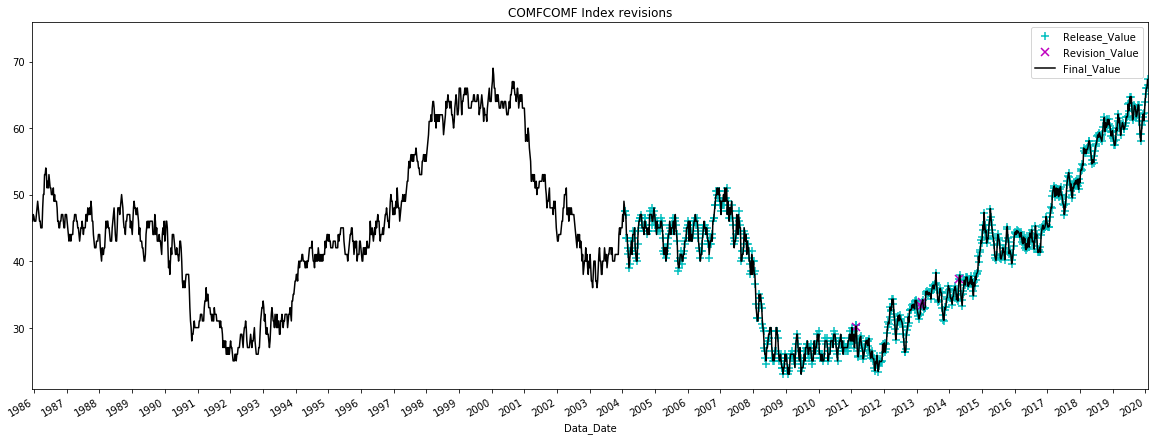

In [31]:
### RUN TO TESTING: FILLED ECO INDICES DATA PLOTTING TO VISUAL CONTROL

### Index choosing:
str_test_index = 'COMFCOMF Index'
### Data loading:
df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
df_flags = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags)
### Flags printing:
print(df_flags.loc[str_test_index, All])
### Series creating:
df_eco_ind = df_dates_filled.loc[(str_test_index, All), All].droplevel(0)[['Release_Value', 'Revision_Value', 'Final_Value']]
date_xlim_start = df_eco_ind.index.min()
date_xlim_finish = df_eco_ind.index.max()
#date_xlim_start = datetime(1984, 12, 31)
date_xlim_finish = datetime(2020, 1, 31)
flo_ylim_min = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].min().min()
flo_ylim_max = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].max().max()
tup_ylim = (flo_ylim_min - abs(flo_ylim_min) / 10, flo_ylim_max + abs(flo_ylim_max) / 10)
#ax_eco_ind = df_eco_ind.plot(figsize = (11, 2), title = str_test_index + ' revisions',                              
ax_eco_ind = df_eco_ind.plot(figsize = (20, 7.5), title = str_test_index + ' revisions', 
                style = ['c+', 'mx', 'k-'], markersize = 7.5, markeredgewidth = 1.5, 
                xlim = (date_xlim_start, date_xlim_finish), ylim = tup_ylim, x_compat = True)
ax_eco_ind.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
ax_eco_ind.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))                
plt.show() 

In [32]:
### RUN TO RE-EXPORT DATA: VALUES STACKING

### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
### Release pair stacking:
df_release_pair = df_dates_filled[['Release_Date', 'Release_Value']]
df_release_pair.columns = ['Observation_Date', 'Index_Value']
df_release_pair = df_release_pair.dropna()
ser_release_based = df_release_pair.set_index('Observation_Date', append = True).squeeze()
#df_release_pair['Stage'] = 'Release'
#ser_release_based = df_release_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### First revision pair stacking:
df_revision_pair = df_dates_filled[['Revision_Date', 'Revision_Value']]
df_revision_pair.columns = ['Observation_Date', 'Index_Value']
df_revision_pair = df_revision_pair.dropna()
ser_revision_based = df_revision_pair.set_index('Observation_Date', append = True).squeeze()
#df_revision_pair['Stage'] = 'First Revision'
#ser_revision_based = df_revision_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### Final revision pair stacking:
df_final_pair = df_dates_filled[['Final_Date', 'Final_Value']]
df_final_pair.columns = ['Observation_Date', 'Index_Value']
df_final_pair = df_final_pair.dropna()
ser_final_based = df_final_pair.set_index('Observation_Date', append = True).squeeze()
#df_final_pair['Stage'] = 'Final Revision'
#ser_final_based = df_final_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### Vectors aggregating:
ser_history_raw = ser_final_based.combine_first(ser_revision_based).combine_first(ser_release_based).dropna().sort_index()

In [33]:
### RUN TO RE-EXPORT DATA: FREQUENCY RECREATING

### 84 : BAKETOT Index frequency recreating:
ser_history_raw.loc['BAKETOT Index', pd.to_datetime('1994-12-23'), pd.to_datetime('1994-12-23')] = np.NaN
ser_history_raw.loc['BAKETOT Index', pd.to_datetime('1995-12-22'), pd.to_datetime('1995-12-22')] = np.NaN
### 85 : IEIPIMOM Index frequency recreating:
ser_history_raw.loc['IEIPIMOM Index', pd.to_datetime('2004-08-31'), pd.to_datetime('2004-08-31')] = np.NaN
### 86 : IERSVMOM Index frequency recreating:
ser_history_raw.loc['IERSVMOM Index', pd.to_datetime('2001-01-31'), pd.to_datetime('2001-01-31')] = np.NaN
ser_history_raw.loc['IERSVMOM Index', pd.to_datetime('2001-02-28'), pd.to_datetime('2001-02-28')] = np.NaN
### 87 : ITBCI Index frequency recreating:
ser_history_raw.loc['ITBCI Index', pd.to_datetime('2020-04-30'), pd.to_datetime('2020-04-30')] = np.NaN
### 88 : ITPSSA Index frequency recreating:
ser_history_raw.loc['ITPSSA Index', pd.to_datetime('2020-04-30'), pd.to_datetime('2020-04-30')] = np.NaN
### 89 : JCOMHCF Index frequency recreating:
idx_ticker_date = ser_history_raw.loc[['JCOMHCF Index'], All, All].index.get_level_values('Data_Date').unique()
idx_ticker_date = pd.date_range(start = '1984-12-31', end = '2004-03-31', freq = 'M').difference(idx_ticker_date)
idx_ticker_reindex = pd.MultiIndex.from_tuples(tuple(zip(['JCOMHCF Index'] * len(idx_ticker_date), idx_ticker_date, idx_ticker_date)))
ser_ei_to_add = pd.Series(np.NaN, index = idx_ticker_reindex)
ser_ei_to_add.index.names = ser_history_raw.index.names
ser_history_raw = pd.concat([ser_history_raw, ser_ei_to_add], axis = 0)
### 90 : JNPIY Index frequency rerceating:
ser_history_raw.loc['JNPIY Index', pd.to_datetime('2001-02-28'), pd.to_datetime('2001-02-28')] = np.NaN
### 91 : MAPMINDX Index frequency recreating:
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-05-31'), pd.to_datetime('2016-05-31')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-06-30'), pd.to_datetime('2016-06-30')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-07-31'), pd.to_datetime('2016-07-31')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-08-31'), pd.to_datetime('2016-08-31')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-09-30'), pd.to_datetime('2016-09-30')] = np.NaN
### 92 : MPMIGBMA Index frequency recreating:
idx_ticker_date = pd.date_range(start = '2014-01-31', end = '2015-11-30', freq = 'M')
idx_ticker_reindex = pd.MultiIndex.from_tuples(tuple(zip(['MPMIGBMA Index'] * len(idx_ticker_date), idx_ticker_date, idx_ticker_date)))
ser_ei_to_add = pd.Series(np.NaN, index = idx_ticker_reindex)
ser_ei_to_add.index.names = ser_history_raw.index.names
ser_history_raw = pd.concat([ser_history_raw, ser_ei_to_add], axis = 0)
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2012-05-31'), pd.to_datetime('2012-05-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2013-02-28'), pd.to_datetime('2013-02-28')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-01-31'), pd.to_datetime('2016-01-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-02-29'), pd.to_datetime('2016-02-29')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-06-30'), pd.to_datetime('2016-06-30')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-07-31'), pd.to_datetime('2016-07-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-08-31'), pd.to_datetime('2016-08-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-12-31'), pd.to_datetime('2016-12-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2017-03-31'), pd.to_datetime('2017-03-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2017-04-30'), pd.to_datetime('2017-04-30')] = np.NaN
### 93 : NEISIYOY Index frequency recreating:
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('1999-07-31'), pd.to_datetime('1999-07-31')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('1999-08-31'), pd.to_datetime('1999-08-31')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('2000-06-30'), pd.to_datetime('2000-06-30')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('2000-07-31'), pd.to_datetime('2000-07-31')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('2000-09-30'), pd.to_datetime('2000-09-30')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('2000-11-30'), pd.to_datetime('2000-11-30')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('2001-07-31'), pd.to_datetime('2001-07-31')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('2002-07-31'), pd.to_datetime('2002-07-31')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('2003-07-31'), pd.to_datetime('2003-07-31')] = np.NaN
### 94 : NERS20Y Index frequency recreating:
ser_history_raw.loc['NERS20Y Index', pd.to_datetime('2001-07-31'), pd.to_datetime('2001-07-31')] = np.NaN
### 95 : PTCCI Index frequency recreating:
ser_history_raw.loc['PTCCI Index', pd.to_datetime('2004-05-31'), pd.to_datetime('2004-05-31')] = np.NaN
### 96 : PTCPHAMM Index frequency recreating:
ser_history_raw.loc['PTCPHAMM Index', pd.to_datetime('2019-01-31'), pd.to_datetime('2019-01-31')] = np.NaN
### 97 : UKCCI Index frequency recreating:
ser_history_raw.loc['UKCCI Index', pd.to_datetime('1995-05-31'), pd.to_datetime('1995-05-31')] = np.NaN
### 98 - 108 : Dropped to keep only one represantative from country in the particular group:
ser_history_raw.drop(['ITISTSAM Index', 'NEISIYOY Index', 'PTISTOTM Index', 'SLIPTIYY Index', 'SPIOWAYY Index', 'IERSVMOM Index', 'ITNSSTN Index', 'SPRSRAY Index',
                      'IEUELV Index', 'IEUEMOM Index', 'SLWIIYOY Index'], level = 'Index_Name', inplace = True)
### 109 - 123 : Dropped due to weak correlation with other particular group members:
ser_history_raw.drop(['SKCCCONC Index', 'GRZEEUEX Index', 'IEIPIMOM Index', 'IEPPIEUM Index', 'MTEF4C Index', 'JNVHSYOY Index', 'JNBTCASE Index', 'JNLSUCTL Index',
                      'HPIMMOM% Index', 'CICRTOT Index', 'PXFECHNG Index', 'UKMSB3PS Index', 'UKAWXTOM Index', 'ITNHMOM Index', 'SVAWRYOY Index'], 
                     level = 'Index_Name', inplace = True)
### Index sorting:
ser_history_raw = ser_history_raw.sort_index()
### Results saving:
ser_history_raw.to_hdf(str_path_bb_idx_hdf, key = str_key_raw_history, mode = 'a')

In [34]:
### RUN TO TESTING: FREQUENCY CONTROL

ser_history_raw = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_history)
ser_idx_test = ser_history_raw.to_frame().reset_index('Data_Date')['Data_Date'].squeeze().reset_index('Observation_Date', drop = True)
ser_idx_test = ser_idx_test.groupby('Index_Name', group_keys = False).apply(lambda ser_ticker: ser_ticker.drop_duplicates())
df_idx_test = ser_idx_test.groupby('Index_Name').apply(lambda ser_ticker: (ser_ticker - ser_ticker.shift()).dt.days).groupby('Index_Name').agg(['min', 'max', 'median'])
df_idx_test['delta'] = df_idx_test['max'] - df_idx_test['min']
df_idx_test.sort_values('delta')

,min,max,median,delta
Index_Name,,,,
INJCSP Index,7.0,7.0,7.0,0.0
COMFCOMF Index,7.0,7.0,7.0,0.0
BAKETOT Index,7.0,7.0,7.0,0.0
INJCJC Index,7.0,7.0,7.0,0.0
GDP CQOQ Index,90.0,92.0,91.0,2.0
...,...,...,...,...
IECPEUIQ Index,28.0,31.0,31.0,3.0
IECPIMOM Index,28.0,31.0,31.0,3.0
IECSINDX Index,28.0,31.0,31.0,3.0


In [35]:
### RUN TO RE-EXPORT DATA: HISTORY REINDEXATION TO OBSERVATION DATE BUSINESS DAILY MATRIX STRUCTURE (PRELIMINARY ACTIONS)

### Data loading:
ser_history_raw = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_history)
### Moving all dates to tne nearest Business day:
df_history_raw = ser_history_raw.to_frame().reset_index('Observation_Date')
df_history_raw['Observation_Date'] = df_history_raw['Observation_Date'] + 0 * pd.offsets.BDay()
ser_history_bday = df_history_raw.set_index('Observation_Date', append = True).squeeze()
ser_history_bday = ser_history_bday.loc[All, All, idx_date_range]
### Data adding to hdf collection:
ser_history_bday.to_hdf(str_path_bb_idx_hdf, key = str_key_bday_history, mode = 'a') ### BDay moved observation dates

In [ ]:
### RUN TO RE-EXPORT DATA: HISTORY DATA DIAGONAL EXTRACTION

def get_diagonal(ser_name, idx_date_range):
    ### Defining triangle extraction:
    def triangle_filter(ser_date):
        date_diag = ser_date.index.get_level_values('Data_Date')[0]
        ser_result = ser_date.droplevel('Data_Date')
        ser_result = ser_result[ser_result.index >= date_diag] 
        return ser_result    
    ### EI name extracting:
    str_index_name = ser_name.index.get_level_values(0)[0]
    ### Observation dates reindexation:    
    print(ser_name.index.get_level_values(0)[0], ': Reindexation')    
    idx_observation_range = ser_name.index.get_level_values('Observation_Date').dropna().unique().intersection(idx_date_range)
    ser_full = ser_name.droplevel('Index_Name').unstack('Data_Date').reindex(idx_observation_range).stack('Data_Date', dropna = False).squeeze()
    ser_full = ser_full.swaplevel()
    ser_full.index.rename('Observation_Date', level = -1, inplace = True)    
    ### Forward filling for each data date:
    ser_full = ser_full.groupby('Data_Date').ffill()   
    ### Diagonalization:
    ser_triangle = ser_full.groupby('Data_Date').apply(triangle_filter).sort_index()
    ### Creating future diagonal vector:
    ser_iter_diag = pd.Series(np.NaN, idx_observation_range)
    ### Looping over unique dates:
    for iter_date in idx_observation_range:
        ### Trying to get the latest data date observation:
        try:
            ser_iter_diag[iter_date] = ser_name.droplevel('Index_Name').loc[All, iter_date].dropna()[-1]
        except:
            pass
    ser_iter_diag = ser_iter_diag.reindex(idx_date_range).ffill()
    ### Results output:
    return ser_iter_diag
### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_bday_history)
### Data transforming:
ser_diagonal_raw = ser_history_bday.groupby('Index_Name').apply(get_diagonal, idx_date_range)    
### Saving results to hdf file:
ser_diagonal_raw.to_hdf(str_path_bb_diag_hdf, key = str_key_diag_daily_raw, mode = 'w')

In [ ]:
### RUN TO RE-EXPORT DATA: GROUPING RESEARCH TO SELECT BASIS TICKERS

### Defining minimum Data Date for each ticker:
ser_history_bday = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_bday_history)
ser_min_date = ser_history_bday.to_frame().reset_index('Data_Date').drop(0, axis = 1).reset_index('Observation_Date', drop = True).squeeze().groupby('Index_Name').agg(min)
ser_min_date.name = 'Min_Date'
ser_max_date = ser_history_bday.to_frame().reset_index('Data_Date').drop(0, axis = 1).reset_index('Observation_Date', drop = True).squeeze().groupby('Index_Name').agg(max)
ser_max_date.name = 'Max_Date'
### Creating description table for all types combinations:
df_flags = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags)
### Defining description table generator:
def type_analyzer(df_group):
    ### Type tickers distribution by region calculating:
    ser_cat_distribution = df_group.groupby('Category').apply(lambda df_category: len(df_category.index))
    ser_cat_distribution['All'] = len(df_group.index)
    ser_cat_distribution = pd.concat([ser_cat_distribution], keys = ['Categories_Distrib'], names = ['Info'])
    ### Adding information about basis ticker for each type:
    ser_cat_distribution['Basic_Ticker_Info', 'Basic_Name'] = df_group['Min_Date'].idxmin()
    ser_cat_distribution['Basic_Ticker_Info', 'Category'] = df_group.loc[df_group['Min_Date'].idxmin(), 'Category']
    ser_cat_distribution['Basic_Ticker_Info', 'Min_Date'] = df_group.loc[df_group['Min_Date'].idxmin(), 'Min_Date']    
    ser_cat_distribution['Basic_Ticker_Info', 'Description'] = df_group.loc[df_group['Min_Date'].idxmin(), 'Description']     
    ### Results output:
    return ser_cat_distribution
### Extending flags table and dropping tickers, that were cleared earlier:
df_flags_typed = pd.concat([df_flags, ser_min_date, ser_max_date], axis = 1, sort = False)
df_flags_typed = df_flags_typed.loc[df_flags_typed['Min_Date'].notna()]
### Flag table reorganizing due to future grouping:
df_flags_typed['Sub_Type'] = df_flags_typed['Type_Second']
df_flags_typed.loc[(df_flags_typed['Type_Prime'] == 'INF') & (df_flags_typed['Type_Second'].isin(['CPI', 'ICP', 'RPI'])), 'Sub_Type'] = 'CPI'
df_flags_typed.loc[(df_flags_typed['Type_Prime'] == 'OUT') & (df_flags_typed['Type_Second'].isin(['IndSales', 'Prod'])), 'Sub_Type'] = 'Prod'
df_flags_typed.loc[(df_flags_typed['Type_Prime'] == 'CON') & (df_flags_typed['Type_Second'].isin(['Cons', 'Sales'])), 'Sub_Type'] = 'Cons'
df_flags_typed.loc[(df_flags_typed['Type_Prime'] == 'ANT') & (df_flags_typed['Type_Second'].isin(['Bus', 'PMI'])), 'Sub_Type'] = 'Bus'
df_flags_typed.loc[(df_flags_typed['Type_Prime'] == 'ANT'), 'Category'] = 'Leading'
### Description table generating:
df_type_info = df_flags_typed.groupby(['Type_Prime', 'Sub_Type', 'Region']).apply(type_analyzer)
df_type_info = df_type_info.unstack(['Info', 'Category'], fill_value = 0)
df_type_info.columns.names = ['', '']
df_type_info = df_type_info.sort_index(axis = 1)
### Description table editing to choose proper basic tickers in some cases:
df_type_info.loc[('ANT', 'Bus', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['EUBCI Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('ANT', 'Bus', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['NAPMPMI Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('ANT', 'Cons', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['EUCCEMU Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('EMP', 'Emp', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['USURTOT Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Orders', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['TMNOCHNG Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Prod', 'Japan'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['JNIPMOM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info[('Basic_Ticker_Info', 'Min_Date')] = pd.to_datetime(df_type_info[('Basic_Ticker_Info', 'Min_Date')])
### Description table additional editing to optimize groups:
df_type_info.loc[('ANT', 'Bus', 'UK'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['ITSR1B Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('CON', 'Cons', 'Japan'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['JNDSTYOY Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('CON', 'Cons', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['PITLCHNG Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('EMP', 'Emp', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['UMRTEMU Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('EMP', 'Emp', 'UK'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['UKUEMOM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('INF', 'CPI', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['ECCPEMUM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('INF', 'CPI', 'UK'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['UKRPXYOY Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('INF', 'CPI', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['PCE CMOM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Orders', 'Japan'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['JNMOCHNG Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Prod', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['EUITEMUM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
## Binding each ticker with it's basis:
df_basic_ticker = df_type_info[[('Basic_Ticker_Info', 'Basic_Name'), ('Basic_Ticker_Info', 'Min_Date')]]
df_basic_ticker.columns = ['Basic_Ticker', 'Basic_Min_Date']
df_flags_typed = df_flags_typed.join(df_basic_ticker, how = 'left', on = ['Type_Prime', 'Sub_Type', 'Region'])
### Clearing basic ticker for basic tickers and resort values to guarantee basic tickers priority:
df_flags_typed.loc[df_flags_typed.index == df_flags_typed['Basic_Ticker'], 'Basic_Ticker'] = ''
df_flags_typed = df_flags_typed.groupby('Basic_Ticker', group_keys = False).apply(lambda df_group: df_group.sort_index())
### Adding flag to define if we need to rebase ticker:
df_flags_typed['Rebase_Flag'] = True
df_flags_typed.loc[df_flags_typed['Basic_Ticker'] == '', 'Rebase_Flag'] = False
df_flags_typed.loc[df_flags_typed['Min_Date'] < (datetime_basis - pd.DateOffset(years = int_not_to_rebase_term)), 'Rebase_Flag'] = False
df_flags_typed.loc[df_flags_typed['Min_Date'] < (df_flags_typed['Basic_Min_Date'] + pd.DateOffset(years = int_not_to_rebase_diff)), 'Rebase_Flag'] = False
### Columns reordering and filtering:
df_flags_typed = df_flags_typed[['Type_Prime', 'Sub_Type', 'Region', 'Category', 'Min_Date', 'Max_Date', 'Frequency', 'Processing', 'Base', 'SA_Status', 'Negative', 
                                 'Rebase_Flag', 'Basic_Ticker', 'Description', 'Data_Source', 'Notes']]
df_flags_typed.index.names = ['Index_Name']
### Results saving:
df_type_info.to_hdf(str_path_bb_idx_hdf, key = str_key_types_info, mode = 'a')
df_flags_typed.to_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed, mode = 'a')
#df_type_info.to_excel('Data_Files/Test_Files/Ticker_Info.xlsx', merge_cells = False)
#df_flags_typed.to_excel('Data_Files/Test_Files/Ticker_Info.xlsx', merge_cells = False)

In [ ]:
### RUN TO RE-EXPORT DATA: HISTORY DATA TRANSFORMATION (REINDEXATION, FLAGS IMPLEMENTATION, Z-SCORING)

### Defining Economic Index series transformation:
def complex_transform(ser_name, idx_date_range, df_flags, int_max_name_length, int_min_years, bool_perform_sa = False):
    ### Local constants definition:
    dict_interval = {}
    dict_interval['Q'] = 4
    dict_interval['M'] = 12
    dict_interval['W'] = 52      
    ### Defining triangle extraction:
    def triangle_filter(ser_date):
        ### Extracting particular Data Date:
        date_diag = ser_date.index.get_level_values('Data_Date')[0]
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Data_Date')
        ### Filtering over-diagonal values:
        ser_result = ser_result[ser_result.index >= date_diag] 
        ### Results output:
        return ser_result
    ### Year-over-year-percent ticker values transforming to stock-like series:
    def yoy_to_level(ser_date, int_step):
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Observation_Date')
        ### Basis initiating:
        flo_basement = 1.0
        ### Factor initiating: 
        flo_next_brick  = 1.0
        ### Looping over month numbers:
        for iter_period in range(min(int_step, len(ser_result.index))):         
            ### Basement building up:
            flo_basement = flo_basement * flo_next_brick
            ### Next basement brick producing:
            flo_next_brick = ((flo_next_brick ** (iter_period)) * (ser_result.iloc[iter_period] ** (1 / int_step))) ** (1 / (iter_period + 1)) 
            ### Jumping cumulative product performing:
            idx_iter_data = ser_result.index[iter_period :: int_step]
            ser_result.loc[idx_iter_data] = ser_result.loc[idx_iter_data].cumprod() * flo_basement       
        ### Results output:            
        return ser_result    
    ### X13 ARIMA Seasonality adjustment model:
    def perform_x13_sa(ser_date):
        ### Dropping constant level:        
        ser_result = ser_date.droplevel('Observation_Date')
        ### Check for minimal quantity of observations to z-score:
        if (ser_result.last_valid_index() - ser_result.first_valid_index()).days >= (int_min_years * 365):   
            ### Naming series for x13 performing:
            ser_result.name = 'Ticker'
            ### Calculating shift value to make all series positive:
            flo_positron = abs(ser_result.min()) * 2
            try:
                ### Performing seasonality adjustment:
                ser_result = x13_arima_analysis(ser_result + flo_positron, outlier = True, trading = True).seasadj - flo_positron
                print('SA success : ', ser_date.index.get_level_values('Observation_Date')[0])                 
            except:
                print('SA error : ', ser_date.index.get_level_values('Observation_Date')[0]) 
        ### Results output:                
        return ser_result 
    ### Extracting Observation Date column for ticker:
    def get_obs_date_vector(str_ticker, str_date, bool_exact_date = False, bool_drop_levels = True):
        ### Vector for exact date:
        if bool_exact_date:
            ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
        ### Vector for nearest date:        
        else:
            ### Loading full ticker series:        
            ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
            ### Extracting data for max date less or equal to needed date:
            ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
        ### Dropping constant index levels if needed:
        if bool_drop_levels:
            return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
        else:
            return ser_obs_date    
    ### Defining time-vector z-scoring procedure:    
    def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj, 
                        str_basis_index, bool_rebase_flag, list_continue_rebase):
        ### Check for empty vector (doing nothing):
        if ser_date.count():
            ### Check for non-constant vector:
            if (ser_date.std() > flo_tolerance):
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                    ### Calculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                    bool_to_winsor = True   
                    int_iter = 1
                    while (bool_to_winsor): 
                        int_iter += 1                
                        ### Value based winsorization:                
                        ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                        ### Recalculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                        ### Checking for boundaries and steps:
                        if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                            bool_to_winsor = False
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
            else:
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                    ### Constant values demeaning:
                    ser_date = ser_date - ser_date.mean()
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')                    
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
        ### Memory optimization:
        ser_date = ser_date.astype('float32')
        return ser_date    
    ### EI name extracting:
    str_index_name = ser_name.index.get_level_values(0)[0]
    ### Observation dates reindexation:    
    print(ser_name.index.get_level_values(0)[0], ': Reindexation')    
    idx_observation_range = ser_name.index.get_level_values('Observation_Date').unique().intersection(idx_date_range).sort_values()
    ser_full = ser_name.droplevel('Index_Name').unstack('Data_Date').reindex(idx_observation_range).stack('Data_Date', dropna = False).squeeze()
    ser_full = ser_full.swaplevel()
    ser_full.index.rename('Observation_Date', level = -1, inplace = True)    
    ### Forward filling for each data date:
    ser_full = ser_full.groupby('Data_Date').ffill()   
    ### Diagonalization:
    ser_triangle = ser_full.groupby('Data_Date').apply(triangle_filter).sort_index()
    ### Flags extracting:
    ser_flags = df_flags.loc[str_index_name, All].squeeze() 
    ### 'TAR' type checking:
    if (ser_flags['Type_Prime'] == 'TAR'):
        print(str_index_name, ': TAR Primary Type ignoring')        
        pass
    ### Flags-based transforming:
    else:
        ### Indices of NA values collecting:
        idx_isna = ser_triangle.loc[ser_triangle.isna()].index
        ### Transforming to stock-like series:
        if (ser_flags['Processing'] in ['Index', 'Level', 'Level%']):
            ser_stock = ser_triangle
        elif (ser_flags['Processing'] == 'Flow'):
            print(str_index_name, ': Transformation to stock-like series: Cumulative sum')
            ### Filling empty values:
            ser_triangle = ser_triangle.fillna(0)
            ### Cumulative sum for each observation date calculating:
            ser_stock = ser_triangle.groupby('Observation_Date').cumsum()
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN
        else:
            print(str_index_name, ': Transformation to stock-like series: Cumulative product')
            ### Filling empty values:
            ser_triangle = ser_triangle.fillna(0)
            ### Percents to multipliers converting:
            ser_stock = 1 + ser_triangle / 100
            ### Calculating with needed periodicity:
            if (ser_flags['Frequency'] == 'Monthly'):
                int_step = dict_cumprod_step[ser_flags['Processing']]
                ### Year-by-year cumprod with rebasing:
                ser_stock = ser_stock.groupby('Observation_Date').apply(yoy_to_level, int_step).swaplevel().sort_index()
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN
        ### Seasonality adjustment testing:
        if bool_perform_sa:
            print(str_index_name, ': Seasonality adjustment')            
            ### Filling empty values:            
            ser_stock = ser_stock.groupby('Observation_Date').ffill()
            ser_stock = ser_stock.groupby('Observation_Date').apply(perform_x13_sa).swaplevel().sort_index()
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN                        
        ### Transforming to YoY series:
        if (ser_flags['Processing'] == 'Index'):
            ### Debasing only:
            print(str_index_name, ': Transformation to YoY series: Debasing')            
            ser_yoy = ser_stock - ser_flags['Base']
        elif (ser_flags['Processing'] in ['Flow', 'Level']):    
            ### Simple difference:
            print(str_index_name, ': Transformation to YoY series: Simple difference')
            ### Shifting lag defining:
            if (ser_flags['Frequency'] in dict_yoy_shift.keys()):
                int_yoy_shift = dict_yoy_shift[ser_flags['Frequency']]
            else:
                int_yoy_shift = dict_yoy_shift['Other']            
            ### Stock-like series differing:
            ser_yoy = ser_stock.groupby('Observation_Date', group_keys = False).apply(lambda ser_obs_date: ser_obs_date - ser_obs_date.shift(int_yoy_shift))
        else:      
            ### Difference with dividing:
            print(str_index_name, ': Transformation to YoY series: Difference with dividing')
            ### Shifting lag defining:
            if (ser_flags['Frequency'] in dict_yoy_shift.keys()):
                int_yoy_shift = dict_yoy_shift[ser_flags['Frequency']]
            else:
                int_yoy_shift = dict_yoy_shift['Other']
            ### Stock-like series differing:
            ser_yoy = ser_stock.groupby('Observation_Date', group_keys = False)\
                               .apply(lambda ser_obs_date: (ser_obs_date / ser_obs_date.shift(int_yoy_shift) - 1))  
        ser_yoy.name = 'YoY'
        ### Negative flag check:
        if (ser_flags['Negative'] == 1):
            ser_yoy = -ser_yoy
        ### Z-scoring across the observation dates:
        print(ser_name.index.get_level_values(0)[0], ': Z-scoring across the observation dates')
        ### To stop rebasing when basic ticker (std, mean) are close to (1, 0):
        list_continue_rebase = [True] 
        ### Adjusting Z-score period limit for some groups:
        if (ser_flags['Data_Source'] == 'Markit'):
            int_min_years_adj = int_min_years - 1
        else:
            int_min_years_adj = int_min_years
        ### Z-score tranformation:
        ser_yoy_z = ser_yoy.groupby('Observation_Date')\
                           .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_adj,
                                      ser_flags['Basic_Ticker'], ser_flags['Rebase_Flag'], list_continue_rebase)       
        ### Adding results to matrix cube:
        pd.concat([ser_yoy_z], keys = [str_index_name], names = ['Index_Name']).to_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, format = 'table',
                                                                                       complevel = 9, append = True, mode = 'a',
                                                                                       min_itemsize = {'Index_Name': int_max_name_length})    
#    ### Results output:
#    return pd.concat([ser_yoy_z], keys = [str_index_name], names = ['Index_Name'])

### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_bday_history)
ser_history_bday = ser_history_bday.reindex(df_flags_typed.index, level = 'Index_Name')
### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
### Previous HDF file deleting:
if os.path.isfile(str_path_bb_matrix_hdf):
    os.remove(str_path_bb_matrix_hdf)
### Maximum length calculating (for HDF manipulations):
int_max_name_length = max(ser_history_bday.index.levels[0].str.len())
#### Testing:
#import tables
#tables.file._open_files.close_all()
#list_test_ticker = ['EUBCI Index', 'CICRTOT Index', 'MPMIITSA Index', 'GRZECURR Index']
#ser_history_bday_test = ser_history_bday.loc[list_test_ticker, All, All]
#ser_test_cube = ser_history_bday_test.groupby('Index_Name', group_keys = False)\
#                                     .apply(complex_transform, idx_date_range, df_flags_typed, int_max_name_length, int_min_years)
### Data transforming:
ser_history_bday.groupby('Index_Name').apply(complex_transform, idx_date_range, df_flags_typed, int_max_name_length, int_min_years)

In [58]:
### TEMP: RESULTS CHECK

#ser_history_bday_test.to_excel('Data_Files/Test_Files/Processing_test.xlsx', merge_cells = False)
#set_res_test.to_excel('Data_Files/Test_Files/Processing_test.xlsx', merge_cells = False)
#pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z).loc['CHPMINDX Index', All, All]#.to_excel('Data_Files/Test_Files/Processing_test.xlsx', merge_cells = False)

In [ ]:
### RUN TO RE-EXPORT DATA: Z_SCORED EI DIAGONAL CONSTRUCTING:

### Creating container for tickers diagonals:
dict_ei_diag = {}
### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_bday_history)
### Tickers list preparing:
idx_ticker_list = ser_history_bday.index.levels[0]
### Looping over tickers:
for iter_ticker in idx_ticker_list:
    ### Loading matrix for each ticker:
    ser_iter_matrix = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == iter_ticker').droplevel('Index_Name')
    ### Excluding TAR tickers:
    if (len(ser_iter_matrix) > 0):
        print(iter_ticker, 'performing') 
        ### Extracting unique observation dates for each ticker later than diagonal start date:
        idx_date_list = ser_iter_matrix.loc[All, date_diag_start : ].index.dropna().get_level_values('Observation_Date').unique()
        ### Creating future diagonal vector:
        ser_iter_diag = pd.Series(np.NaN, idx_date_list)    
        ### Determining first valid date and first date to place z-scoring results on diagonal:
        ### Looping over unique dates:
        for iter_date in idx_date_list:
            ### Trying to get the latest data date observation:
            try:
                ser_iter_diag[iter_date] = ser_iter_matrix.loc[All, iter_date].dropna()[-1]
            except:
                pass
        ### Checking for data earlier than diagonal start date:
        if ((ser_iter_matrix.index.get_level_values('Observation_Date').unique().min() < date_diag_start) & pd.notna(ser_iter_diag.values[0])):
            ### Turning diagonal start date column to diagonal with data dates as index dates:
            ser_iter_start_col = ser_iter_matrix.loc[ : idx_date_list[0], [idx_date_list[0]]]
            ### Ticker values on the date to turn:
            list_iter_values_to_turn = ser_iter_start_col.values
            ### Implementing lag before the announcement for the first valid observation date (3 years of data dates with equal first valid index):
            int_release_lag = (ser_iter_start_col.dropna().index[-1][-1] - ser_iter_start_col.dropna().index[-1][0]).days
            ### Taking announcement dates as an index for first column values:
            list_iter_index_to_turn = ser_iter_start_col.index.get_level_values('Data_Date') + pd.offsets.Day(int_release_lag)
            ### Modified column to turn:
            ser_iter_to_turn = pd.Series(list_iter_values_to_turn, index = list_iter_index_to_turn)
            ### Dropping repeated dates and empty dates:
            ser_iter_to_turn = ser_iter_to_turn.groupby(level = 0).apply(lambda ser_date: ser_date[-1]).dropna()
            ### Cutting series not to intersect with diagonal index:
            ser_iter_to_turn = ser_iter_to_turn.loc[ : idx_date_list[0] - pd.offsets.Day(1)]
            ### Joining series:
            ser_iter_diag = pd.concat([ser_iter_to_turn, ser_iter_diag], axis = 0).sort_index() 
        ### Reindexation to business daily vector and forward filling:
        ser_iter_diag = ser_iter_diag.ffill().reindex(idx_date_range).ffill()
        ### Saving ticker diagonal to the container:
        dict_ei_diag[iter_ticker] = ser_iter_diag
    else:
        print(iter_ticker, 'is a member of TAR/GDP group')
### Aggregating ticker diagonals:
ser_diagonal_z = pd.concat(dict_ei_diag, axis = 0)
ser_diagonal_z.index.names = ['Index_Name', 'Date']
ser_diagonal_z.name = 'EI_diagonal'
### Saving results to hdf file:
ser_diagonal_z.to_hdf(str_path_bb_diag_hdf, key = str_key_diag_daily_z, mode = 'a')

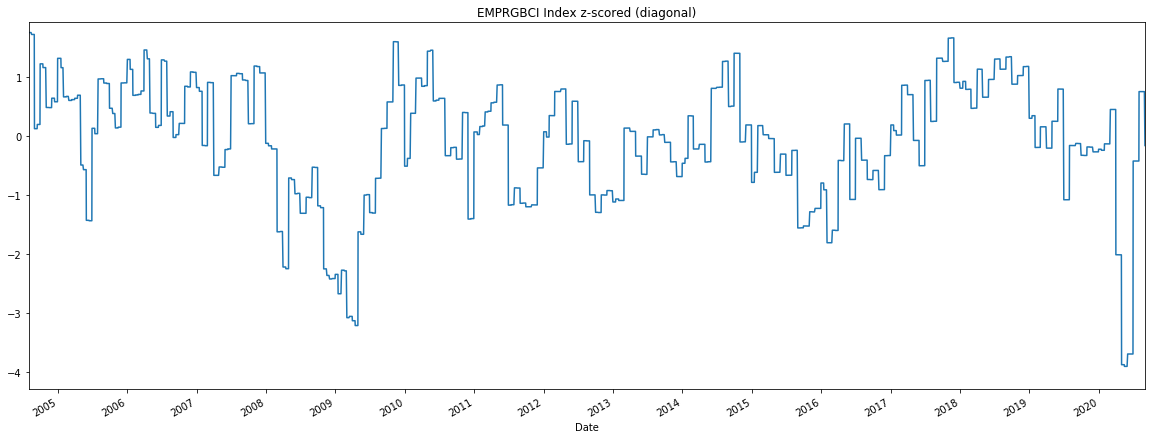

In [41]:
### RUN TO TESTING: DIAGONALS PLOTTING

str_test_ticker = 'EMPRGBCI Index'
ser_diagonal = pd.read_hdf(str_path_bb_diag_hdf, key = str_key_diag_daily_z)
#ser_diagonal = pd.read_hdf(str_path_bb_diag_hdf, key = str_key_diag_daily_raw)
ser_eco_ind = ser_diagonal.loc[str_test_ticker, All].droplevel(0).dropna()
date_xlim_start = ser_eco_ind.index.min()
date_xlim_finish = ser_eco_ind.index.max()
flo_ylim_min = ser_eco_ind.loc[date_xlim_start : date_xlim_finish].min()
flo_ylim_max = ser_eco_ind.loc[date_xlim_start : date_xlim_finish].max()
tup_ylim = (flo_ylim_min - abs(flo_ylim_min) / 10, flo_ylim_max + abs(flo_ylim_max) / 10)
ax_eco_ind = ser_eco_ind.plot(figsize = (20, 7.5), title = str_test_ticker + ' z-scored (diagonal)', 
                              xlim = (date_xlim_start, date_xlim_finish), ylim = tup_ylim, x_compat = True)
ax_eco_ind.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
ax_eco_ind.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))                
plt.show() 

In [56]:
### RUN TO TESTING: DIAGONALS EXPORT TO MS EXCEL

ser_diagonal_z = pd.read_hdf(str_path_bb_diag_hdf, key = str_key_diag_daily_z)
ser_diagonal_z.unstack('Index_Name').to_excel('Data_Files/Test_Files/Diag_Eco_Indices_z.xlsx', merge_cells = False)
ser_diagonal_raw = pd.read_hdf(str_path_bb_diag_hdf, key = str_key_diag_daily_raw)
ser_diagonal_raw.unstack('Index_Name').to_excel('Data_Files/Test_Files/Diag_Eco_Indices_raw.xlsx', merge_cells = False)

In [59]:
### RUN TO TESTING: LAST COLUMN CORRELATION CONTROL

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
### Creating container for tickers diagonals:
dict_last_col = {}
### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_bday_history)
### Tickers list preparing:
idx_ticker_list = ser_history_bday.index.levels[0]
### Looping over tickers:
for iter_ticker in idx_ticker_list:
    dict_last_col[iter_ticker] = get_obs_date_vector(iter_ticker, date_end.strftime('%Y-%m-%d'), bool_exact_date = False, bool_drop_levels = True)
### Aggregating ticker's last columns:
ser_last_col = pd.concat(dict_last_col, axis = 0)
ser_last_col.index.names = ['Index_Name', 'Date']
ser_last_col.name = 'Last_Column' 
ser_last_col_filled = ser_last_col.to_frame().join(df_flags_typed[['Type_Prime', 'Sub_Type', 'Region', 'Category']], how = 'left')\
                                  .set_index(['Type_Prime', 'Sub_Type', 'Region', 'Category'], append = True).squeeze()

In [60]:
### RUN TO TESTING: LAST COLUMN CORRELATION CONTROL

### Defining of category dependent Ticker data fill:
def conditional_fill(ser_vector, str_category, int_limit = 20):
    if (str_category == 'Leading'):
        ser_filled = ser_vector.ffill(limit = int_limit)
    else:
        ser_filled = ser_vector.bfill(limit = int_limit).ffill(limit = int_limit)
    ### Results output:
    return ser_filled
### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)

### Filling tickers last columns:
ser_last_col_reindex = ser_last_col.unstack('Index_Name').stack(dropna = False).swaplevel().sort_index()
ser_last_col_reindex.name = 'Last_Column'
df_last_col_filled = ser_last_col_reindex.to_frame().join(df_flags_typed['Category'], how = 'left')
ser_last_col_filled = df_last_col_filled.groupby('Index_Name', group_keys = False)\
                                        .apply(lambda df_group: conditional_fill(df_group['Last_Column'], df_group['Category'][0]))
### Adding type attributes:
ser_last_col_typed = ser_last_col_filled.to_frame().join(df_flags_typed[['Type_Prime', 'Sub_Type', 'Region', 'Basic_Ticker']], how = 'left').reset_index('Index_Name')\
                                                   .set_index(['Type_Prime', 'Sub_Type', 'Region'], append = True)
### Filling 'Basic Ticker' column for basic tickers:
ser_last_col_typed.loc[ser_last_col_typed['Basic_Ticker'] == '', 'Basic_Ticker'] = ser_last_col_typed.loc[ser_last_col_typed['Basic_Ticker'] == '', 'Index_Name']
ser_last_col_typed = ser_last_col_typed.set_index(['Index_Name', 'Basic_Ticker'], append = True).squeeze()\
        .sort_index(level = ['Type_Prime', 'Sub_Type', 'Region', 'Basic_Ticker']).reorder_levels(['Index_Name', 'Date', 'Type_Prime', 'Sub_Type', 'Region', 'Basic_Ticker'])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2848: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [61]:
### RUN TO TESTING: LAST COLUMN CORRELATION CONTROL

### Defining group correlation stats calculation:
def get_group_correlation_stats(ser_group, str_basic_ticker):
    if str_basic_ticker:
        df_corr_values = ser_group.unstack('Index_Name').corr()
        df_corr_values = df_corr_values[df_corr_values < 1.0]
        if (len(df_corr_values.index) > 1): 
            ser_corr_stats = pd.Series([len(df_corr_values),
                                        df_corr_values[df_corr_values < 0.2].count().sum() // 2,
                                        df_corr_values[df_corr_values < 0.2].count().sum() / ((len(df_corr_values.index) - 1) * len(df_corr_values.index)),
                                        df_corr_values.min().min(), 
                                        df_corr_values.mean().mean(), 
                                        df_corr_values.median().median(),
                                        df_corr_values.max().max()],
                                       index = ['size', 'weak pairs number', 'weak pairs proportion', 'min', 'mean', 'median', 'max']).round(3)
        else:
            ser_corr_stats = pd.Series(['Single ticker'] * 7, index = ['size', 'weak pairs number', 'weak pairs proportion', 'min', 'mean', 'median', 'max'])
        return ser_corr_stats.fillna('Single ticker')
### Getting correlation stats for each group:
ser_last_col_corr = ser_last_col_typed.groupby(['Type_Prime', 'Sub_Type', 'Region'])\
                .apply(lambda ser_group: get_group_correlation_stats(ser_group.droplevel(['Type_Prime', 'Sub_Type', 'Region', 'Basic_Ticker']), ser_group.index[-1][-1]))\
                .unstack(-1)
### Saving results:
ser_last_col_corr.to_excel('Data_Files/Test_Files/Groups_Correlation_Analysis.xlsx', merge_cells = False)

In [77]:
### RUN TO TESTING: LAST COLUMN CORRELATION CONTROL

### Defining pairwise correlations calculation inside the group::
def get_group_correlation_table(ser_group):
    if (len(ser_group.index.get_level_values('Index_Name').unique()) > 1):
        ser_group_cut = ser_group.droplevel(['Type_Prime', 'Sub_Type', 'Region', 'Basic_Ticker'])
        df_group_corr = ser_group_cut.unstack('Index_Name').corr()
        df_group_corr.columns.name = ''
        df_group_corr['Average Corr'] = (df_group_corr.sum(axis = 1) - 1) / (len(df_group_corr.index) - 1)
        df_group_corr.loc['Average Corr'] = list(df_group_corr['Average Corr'].values) + [df_group_corr['Average Corr'].mean()]
        df_group_corr.to_excel(writer, sheet_name = ' '.join(ser_group.index[0][2 : 5]), merge_cells = False)
### Calculating and saving pairwise correlation tables for each group:
with pd.ExcelWriter('Data_Files/Test_Files/Groups_Correlation_Tables.xlsx') as writer:   
    ser_last_col_typed.groupby(['Type_Prime', 'Sub_Type', 'Region'])\
                    .apply(lambda ser_group: get_group_correlation_table(ser_group))        

In [ ]:
### RUN TO AGGREGATE: GROUP DATA CONSOLIDATION

### Defining group aggregation function:
def group_aggregate(ser_group_list):
    ### Defining triangle extraction:
    def triangle_filter(ser_date):
        ### Extracting particular Data Date:
        date_diag = ser_date.index.get_level_values('Data_Date')[0]
        ### Dropping constant level:
        ser_result = ser_date.droplevel(['Index_Name', 'Data_Date'])
        ### Filtering over-diagonal values:
        ser_result = ser_result[ser_result.index >= date_diag] 
        ### Results output:
        return ser_result 
    def conditional_fill(ser_ticker, int_limit = int_fill_limit):
        ### Category loading:
        str_category = df_flags_typed.loc[ser_ticker.index[0][0], 'Category']
        if (str_category == 'Leading'):
            ser_filled = ser_ticker.groupby('Observation_Date').ffill(limit = int_limit)
        else:
            ser_filled = ser_ticker.groupby('Observation_Date').bfill(limit = int_limit).groupby('Observation_Date').ffill(limit = int_limit)
        ### Results output:
        return ser_filled   
    ### Defining time-vector z-scoring procedure:    
    def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj):
        ### Check for empty vector (doing nothing):
        if ser_date.count():
            ### Check for non-constant vector:
            if (ser_date.std() > flo_tolerance):
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                    ### Calculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                    bool_to_winsor = True   
                    int_iter = 1
                    while (bool_to_winsor): 
                        int_iter += 1                
                        ### Value based winsorization:                
                        ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                        ### Recalculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                        ### Checking for boundaries and steps:
                        if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                            bool_to_winsor = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
            else:
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                    ### Constant values demeaning:
                    ser_date = ser_date - ser_date.mean()
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
        ### Memory optimization:
        ser_date = ser_date.astype('float32')
        return ser_date        
    ### Extracting group ticker names:
    list_group_members = ser_group_list.to_list()
    ### Creating ticker data container:
    list_group_matrix = []
    ### Looping over tickers to collect group data:
    for iter_ticker in list_group_members:
        list_group_matrix.append(pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == iter_ticker'))
    ### Group data aggregating:
    ser_group_matrix = pd.concat(list_group_matrix)
    ### Group have more than one member:
    if (len(list_group_members) > 1):    
        ### Union of observation dates defining:
        idx_observation_range = ser_group_matrix.index.get_level_values('Observation_Date').unique().sort_values()
        ### Reindexation of observation dates:
        ser_obs_range = ser_group_matrix.groupby('Index_Name').apply(lambda ser_name: ser_name.droplevel('Index_Name').unstack('Data_Date').reindex(idx_observation_range)\
                                                                                              .stack('Data_Date', dropna = False).squeeze().swaplevel().sort_index())
        ### Filling for each data date:
        ser_obs_range = ser_obs_range.groupby(['Index_Name', 'Data_Date']).ffill()
        ### Union of event dates defining:
        idx_event_range = ser_obs_range.index.get_level_values('Data_Date').unique().sort_values()
        ### Reindexation of observation dates:
        ser_event_range = ser_obs_range.groupby('Index_Name').apply(lambda ser_name: ser_name.droplevel('Index_Name').unstack('Observation_Date').reindex(idx_event_range)\
                                                                                             .stack('Observation_Date', dropna = False).squeeze().sort_index())
        ### Filling for each data date:
        ser_event_range = ser_event_range.groupby(['Index_Name']).apply(conditional_fill, int_fill_limit) 
        ### Cutting by the diagonal:
        ser_triangle = ser_event_range.groupby(['Index_Name', 'Data_Date']).apply(triangle_filter).sort_index() 
        ### Group average taking:
        ser_average = ser_triangle.unstack('Index_Name').mean(axis = 1)    
        ser_average.name = 'Average'
        ### Z-scoring for each observation date:
        ser_average_z = ser_average.groupby('Observation_Date')\
                                   .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years) 
        ### Adding group data to hdf file:
        pd.concat([ser_average_z], keys = [ser_group_list.index[0]], names = ['Type_Prime', 'Sub_Type', 'Region'])\
                                .to_hdf(str_path_group_matrix_hdf, key = str_key_group_matrix, format = 'table', complevel = 9, append = True, mode = 'a',
                                        min_itemsize = {'Type_Prime': int_max_type_prime_len, 'Sub_Type': int_max_sub_type_len, 'Region': int_max_region_len})
#        ### Results output:
#        return ser_average_z        
    else:
        ser_group_matrix.name = 'Average'
        ### Adding group data to hdf file:
        pd.concat([ser_group_matrix.droplevel('Index_Name')], keys = [ser_group_list.index[0]], names = ['Type_Prime', 'Sub_Type', 'Region'])\
                                .to_hdf(str_path_group_matrix_hdf, key = str_key_group_matrix, format = 'table', complevel = 9, append = True, mode = 'a',
                                        min_itemsize = {'Type_Prime': int_max_type_prime_len, 'Sub_Type': int_max_sub_type_len, 'Region': int_max_region_len})
#        ### Results output:
#        return ser_group_matrix.droplevel('Index_Name')        
    ### Success message:
    print(ser_group_list.index[0], 'group average matrix successfully added to file')
### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
### Length limits for levels determination:
int_max_type_prime_len = df_flags_typed['Type_Prime'].str.len().max(axis = 0)
int_max_sub_type_len = df_flags_typed['Sub_Type'].str.len().max(axis = 0)
int_max_region_len = df_flags_typed['Region'].str.len().max(axis = 0)
### Flags converting to group register:
ser_group_register = df_flags_typed[['Type_Prime', 'Sub_Type', 'Region']].reset_index().set_index(['Type_Prime', 'Sub_Type', 'Region']).squeeze()

### Previous HDF file deleting:
if os.path.isfile(str_path_group_matrix_hdf):
    os.remove(str_path_group_matrix_hdf)

### Test customizing:
#str_test_type_prime = 'OUT'
#str_test_sub_type = 'Prod'
#str_test_region = 'US'
#ser_test_ei = ser_group_register.loc[[str_test_type_prime], [str_test_sub_type], [str_test_region]]
#ser_test_ei = ser_group_register.loc[[str_test_type_prime], [str_test_sub_type], All]
#ser_group_mean = ser_test_ei.groupby(['Type_Prime', 'Sub_Type', 'Region'], group_keys = False).apply(group_aggregate)
#ser_group_mean = ser_test_ei.groupby(['Type_Prime', 'Sub_Type', 'Region'], group_keys = False).apply(group_aggregate)

ser_group_register.groupby(['Type_Prime', 'Sub_Type', 'Region'], group_keys = True).apply(group_aggregate)

In [ ]:
### RUN TO RE-EXPORT DATA: Z_SCORED GROUPS DIAGONAL CONSTRUCTING:

### Creating container for groups diagonals:
list_groups_diag = []
### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
### Looping over groups:
for iter_group in df_flags_typed[['Type_Prime', 'Sub_Type', 'Region']].drop_duplicates().sort_values(['Type_Prime', 'Sub_Type', 'Region']).values:
    ser_iter_matrix = pd.read_hdf(str_path_group_matrix_hdf, key = str_key_group_matrix, 
                                  where = '(Type_Prime == iter_group[0]) & (Sub_Type == iter_group[1]) & (Region == iter_group[2])')\
                        .droplevel(['Type_Prime', 'Sub_Type', 'Region'])
    ### Excluding TAR tickers:
    if (len(ser_iter_matrix) > 0):
        print(iter_group, 'performing') 
        ### Extracting unique observation dates for each ticker later than diagonal start date:
        idx_date_list = ser_iter_matrix.loc[All, date_diag_start : ].index.dropna().get_level_values('Observation_Date').unique()
        ### Creating future diagonal vector:
        ser_iter_diag = pd.Series(np.NaN, idx_date_list)    
        ### Determining first valid date and first date to place z-scoring results on diagonal:
        ### Looping over unique dates:
        for iter_date in idx_date_list:
            ### Trying to get the latest data date observation:
            try:
                ser_iter_diag[iter_date] = ser_iter_matrix.loc[All, iter_date].dropna()[-1]
            except:
                pass
        ### Checking for data earlier than diagonal start date:
        if ((ser_iter_matrix.index.get_level_values('Observation_Date').unique().min() < date_diag_start) & pd.notna(ser_iter_diag.values[0])):
            ### Selecting column to be turned:
            ser_iter_to_turn = ser_iter_matrix.loc[ : idx_date_list[0] - pd.offsets.Day(1), [idx_date_list[0]]].droplevel('Observation_Date')
            ### Joining series:
            ser_iter_diag = pd.concat([ser_iter_to_turn, ser_iter_diag], axis = 0).sort_index() 
        ### Reindexation to business daily vector and forward filling:
        ser_iter_diag = ser_iter_diag.ffill().reindex(idx_date_range).ffill()
        ### Saving ticker diagonal to the container:
        list_groups_diag.append(pd.concat([ser_iter_diag], keys = [tuple(iter_group)], names = ['Type_Prime', 'Sub_Type', 'Region']))
    else:
        print(iter_group, 'is a TAR/GDP group')
### Container converting and adding to HDF:
pd.concat(list_groups_diag, axis = 0).to_hdf(str_path_bb_diag_hdf, key = str_key_diag_group_z, mode = 'a')

In [ ]:
### RUN TO AGGREGATE: GROUP EVENT DATES AND OBSERVATION DATES CONSOLIDATING:

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
### Region weights adopting:
ser_region_weight = pd.Series(dict_region_weight)
ser_region_weight.name = 'Region'
### Extracting group indices to groupby:
ser_sub_type = df_flags_typed[['Type_Prime', 'Sub_Type', 'Region']].drop_duplicates().sort_values(['Type_Prime', 'Sub_Type'])\
                                                    .reset_index().set_index(['Type_Prime', 'Sub_Type']).drop('Index_Name', axis = 1).squeeze()
### GDP Dropping:
ser_sub_type = ser_sub_type.drop('TAR', level = 'Type_Prime')
### Adding region weights to group info:
ser_sub_type = ser_sub_type.to_frame().set_index('Region', append = True).join(ser_region_weight, on = 'Region').squeeze().sort_index()
ser_sub_type.name = 'Weight'
### Creating unique event dates container:
set_event_range = set()
### Creating unique observation dates container:
set_obs_range = set()
### Looping over groups to get event dates from matrices:
for iter_group in ser_sub_type.index:
    ### Full group matrix loading:
    ser_iter_group = pd.read_hdf(str_path_group_matrix_hdf, key = str_key_group_matrix, 
                                 where = '(Type_Prime == iter_group[0]) & (Sub_Type == iter_group[1]) & (Region == iter_group[2])')
    ### Unique event dates uniting:
    set_event_range = set_event_range.union(set(ser_iter_group.index.levels[-2]))
    ### Unique event dates uniting:
    set_obs_range = set_obs_range.union(set(ser_iter_group.index.levels[-1]))    
    print(iter_group, 'dates extracted successfully')
### Overall unique event dates sorting:
list_event_range = sorted(set_event_range)
### Overall unique event dates sorting:
list_obs_range = sorted(set_obs_range)
### Dummy event vector constructing and saving:
ser_event_dates = pd.Series(0, index = list_event_range).astype('int8')
ser_event_dates.name = 'Data_Date'
ser_event_dates.to_hdf(str_path_overall_dates_hdf, key = str_key_event_dates, mode = 'w')
### Dummy observation vector constructing and saving:
ser_obs_dates = pd.Series(0, index = list_obs_range).astype('int8')
ser_obs_dates.name = 'Observation_Date'
ser_obs_dates.to_hdf(str_path_overall_dates_hdf, key = str_key_obs_dates, mode = 'a')
### Garbage collecting:
gc.collect()

In [ ]:
### RUN TO AGGREGATE: SUB TYPES AGGREGATING:

### Defining triangle extraction:
def triangle_filter(ser_date):
    ### Extracting particular Data Date:
    date_diag = ser_date.index.get_level_values('Data_Date')[0]
    ### Dropping constant level:
    ser_result = ser_date.droplevel('Data_Date')
    ### Filtering over-diagonal values:
    ser_result = ser_result[ser_result.index >= date_diag] 
    ### Results output:
    return ser_result
### Defining time-vector z-scoring procedure:    
def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj):
    ### Check for empty vector (doing nothing):
    if ser_date.count():
        ### Check for non-constant vector:
        if (ser_date.std() > flo_tolerance):
            ### Check for minimal quantity of observations to z-score:
            if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                ### Calculating of z scores:
                ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                bool_to_winsor = True   
                int_iter = 1
                while (bool_to_winsor): 
                    int_iter += 1                
                    ### Value based winsorization:                
                    ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                    ### Recalculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                    ### Checking for boundaries and steps:
                    if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                        bool_to_winsor = False
            else:
                ### Killing values that we can't z-score
                ser_date.loc[All] = np.NaN
        else:
            ### Check for minimal quantity of observations to z-score:
            if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                ### Constant values demeaning:
                ser_date = ser_date - ser_date.mean()
            else:
                ### Killing values that we can't z-score
                ser_date.loc[All] = np.NaN
    ### Memory optimization:
    ser_date = ser_date.astype('float32')
    return ser_date                
### Defining region averaging:
def sub_type_aggregate(ser_iter_sub):
    gc.collect()
    list_iter_weights = ser_iter_sub.values
    ### Looping over regions:
    for iter_num, iter_index in enumerate(ser_iter_sub.index):
        print(iter_index, ser_iter_sub[iter_index])
        ### Loading group matrix:
        ser_iter_group = pd.read_hdf(str_path_group_matrix_hdf, key = str_key_group_matrix, 
                                where = '(Type_Prime == iter_index[0]) & (Sub_Type == iter_index[1]) & (Region == iter_index[2])')\
                            .droplevel(['Type_Prime', 'Sub_Type', 'Region'])
        print(iter_index, 'matrix loaded')
        ### Observation dates reindexation and forward filling for every event date:
        gc.collect()
        ser_iter_group = ser_iter_group.unstack('Data_Date').reindex(idx_obs_range).ffill(axis = 0).stack('Data_Date', dropna = False).swaplevel().sort_index()
        ser_iter_group.index.names = ['Data_Date', 'Observation_Date']
        print(iter_index, 'observation dates reindexed')        
        ### Event dates reindexation and forward filling for every observation date:
        gc.collect()
        ser_iter_group = ser_iter_group.unstack('Observation_Date').reindex(idx_event_range).ffill(axis = 0).stack('Observation_Date', dropna = False).sort_index()
        ser_iter_group.index.names = ['Data_Date', 'Observation_Date']
        print(iter_index, 'event dates reindexed')        
        ### Triangle filtering:
        gc.collect()
        ser_iter_group = ser_iter_group.astype('float16').groupby('Data_Date').apply(triangle_filter)
        ### Creating dataframe for the future averaging:
        if (iter_num == 0):
            ser_iter_group.name = iter_index[2]
            df_iter_sub = ser_iter_group.to_frame()
        ### Adding column to existing dataframe:    
        else:
            df_iter_sub[iter_index[2]] = ser_iter_group.values
        del ser_iter_group
        gc.collect()
        print(iter_index, 'matrix added to table')
    ### Sub type average calculating:
    ser_mean = columns_average(df_iter_sub, list_iter_weights)
    del df_iter_sub
    gc.collect()
    print(iter_index[: 2], 'mean calculated')
    ### Sub type average z-scoring:
    ser_mean = ser_mean.groupby('Observation_Date').transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years)
    gc.collect()    
    print(iter_index[: 2], 'mean z-scored')
    ### Sub type average adding to the HDF file:
    pd.concat([ser_mean], keys = [iter_index[: 2]], names = ['Type_Prime', 'Sub_Type'])\
                                    .to_hdf(str_path_sub_matrix_hdf, key = str_key_sub_matrix, format = 'table', complevel = 9, append = True, mode = 'a',
                                            min_itemsize = {'Type_Prime': int_max_type_prime_len, 'Sub_Type': int_max_sub_type_len}) 
    print(iter_index[: 2], 'z-scored matrix saved')    
#    ### Results output:    
#    return ser_mean

### Garbage collecting:
gc.collect()
### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
### Region weights adopting:
ser_region_weight = pd.Series(dict_region_weight)
ser_region_weight.name = 'Region'
### Extracting group indices to groupby:
ser_sub_type = df_flags_typed[['Type_Prime', 'Sub_Type', 'Region']].drop_duplicates().sort_values(['Type_Prime', 'Sub_Type'])\
                                                    .reset_index().set_index(['Type_Prime', 'Sub_Type']).drop('Index_Name', axis = 1).squeeze()
### GDP Dropping:
ser_sub_type = ser_sub_type.drop('TAR', level = 'Type_Prime')
### Adding region weights to group info:
ser_sub_type = ser_sub_type.to_frame().set_index('Region', append = True).join(ser_region_weight, on = 'Region').squeeze().sort_index()
ser_sub_type.name = 'Weight'
### Loading dates indices:
idx_event_range = pd.read_hdf(str_path_overall_dates_hdf, key = str_key_event_dates).index
idx_obs_range = pd.read_hdf(str_path_overall_dates_hdf, key = str_key_obs_dates).index
### Length limits for levels determination:
int_max_type_prime_len = ser_sub_type.index.levels[0].str.len().max()
int_max_sub_type_len = ser_sub_type.index.levels[1].str.len().max()
### Previous HDF file deleting:
if os.path.isfile(str_path_sub_matrix_hdf):
    os.remove(str_path_sub_matrix_hdf)
### Aggregation performing:
#ser_test = ser_sub_type.loc['ANT', 'Bus', All].groupby(['Type_Prime', 'Sub_Type']).apply(sub_type_aggregate)
ser_sub_type.groupby(['Type_Prime', 'Sub_Type']).apply(sub_type_aggregate)

In [ ]:
### RUN TO RE-EXPORT DATA: Z_SCORED SUB TYPES DIAGONAL CONSTRUCTING:

### Creating container for groups diagonals:
list_groups_diag = []
### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
### Chunk size defining:
int_chunksize = 10 ** 6
### Looping over sub types:
for iter_group in df_flags_typed[['Type_Prime', 'Sub_Type']].drop_duplicates().sort_values(['Type_Prime', 'Sub_Type']).values:
    ### Check for not GDP:
    if (iter_group[0] != 'TAR')
        ### Iteration container preparing:
        gc.collect()
        list_iter_container = []
        ### Sub type matrix loading:
        print(iter_group, 'loading') 
        for iter_chunk in pd.read_hdf(str_path_sub_matrix_hdf, key = str_key_sub_matrix, chunksize = int_chunksize, 
                                      where = '(Type_Prime == iter_group[0]) & (Sub_Type == iter_group[1]) & (Observation_Date >= date_diag_start)'):
            list_iter_container.append(iter_chunk)
            del iter_chunk
            gc.collect()    
        ### Sub type matrix constructing:
        ser_iter_matrix = pd.concat(list_iter_container, axis = 0).droplevel(['Type_Prime', 'Sub_Type']).sort_index()
        del list_iter_container
        gc.collect()                         
        print(iter_group, 'main diagonal part constructing') 
        ### Extracting unique observation dates for each ticker later than diagonal start date:
        idx_date_list = ser_iter_matrix.index.get_level_values('Observation_Date').unique()
        ### Creating future diagonal vector:
        ser_iter_diag = ser_iter_matrix.groupby('Observation_Date').apply(lambda ser_obs_date: ser_obs_date.dropna()[-1] if (ser_obs_date.count() > 0) else np.NaN)
        ### Checking for data earlier than diagonal start date:
        if (ser_iter_matrix.dropna().loc[All, idx_date_list[0]].index[0] < date_diag_start):
            ### Selecting column to be turned:
            print(iter_group, 'auxiliary diagonal part constructing') 
            ser_iter_to_turn = ser_iter_matrix.loc[ : idx_date_list[0] - pd.offsets.Day(1), [idx_date_list[0]]].droplevel('Observation_Date')
            ### Joining series:
            ser_iter_diag = pd.concat([ser_iter_to_turn, ser_iter_diag], axis = 0).sort_index() 
        ### Reindexation to business daily vector and forward filling:
        ser_iter_diag = ser_iter_diag.ffill().reindex(idx_date_range).ffill()
        ser_iter_diag = ser_iter_diag.astype('float32')
        ### Saving ticker diagonal to the container:
        list_groups_diag.append(pd.concat([ser_iter_diag], keys = [tuple(iter_group)], names = ['Type_Prime', 'Sub_Type']))
        print(iter_group, 'diagonal added to container')
### Container converting and adding to HDF:
ser_sub_type_diag = pd.concat(list_groups_diag, axis = 0)
ser_sub_type_diag.index.set_names(names = 'Data_Date', level = 2, inplace = True)
ser_sub_type_diag.to_hdf(str_path_bb_diag_hdf, key = str_key_diag_sub_z, mode = 'a')

In [23]:
### RUN TO RESULTS DEMONSTRATION: AGGREGATED DIAGONALS EXPORT

#ser_region_diag = pd.read_hdf(str_path_bb_diag_hdf, key = str_key_diag_group_z)
#ser_sub_type_diag = pd.read_hdf(str_path_bb_diag_hdf, key = str_key_diag_sub_z)
#ser_region_diag.unstack(['Type_Prime', 'Sub_Type', 'Region']).to_excel('Data_Files/Test_Files/Region_Diagonals.xlsx', merge_cells = False)
#ser_sub_type_diag.unstack(['Type_Prime', 'Sub_Type']).to_excel('Data_Files/Test_Files/Sub_Type_Diagonals.xlsx', merge_cells = False)

In [ ]:
### RUN TO TEST: SUB TYPE DIAGONALS PLOTTING

### Visualizing pattern defining:
list_style_pattern = ['b--', 'y--', 'g--', 'r--', 'c--', 'm--', 'k-']
### Sub type / Regional diagonals loading:
ser_region_diag = pd.read_hdf(str_path_bb_diag_hdf, key = str_key_diag_group_z)
### Sub type mean diagonals loading:
ser_sub_type_diag = pd.read_hdf(str_path_bb_diag_hdf, key = str_key_diag_sub_z)
### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
### Sub types looping:
for iter_group in df_flags_typed[['Type_Prime', 'Sub_Type']].drop_duplicates().sort_values(['Type_Prime', 'Sub_Type']).values:
    if (iter_group[0] != 'TAR'):
        ### Sub type mean diagonal extracting:
        ser_iter_sub_mean = ser_sub_type_diag.loc[iter_group[0], iter_group[1], All].droplevel(['Type_Prime', 'Sub_Type'])
        ser_iter_sub_mean.index.names = ['Date']
        ser_iter_sub_mean.name = 'Mean'
        ### Sub type regional diagonals extracting:        
        df_iter_region = ser_region_diag.loc[iter_group[0], iter_group[1], All, All].unstack('Region').droplevel(['Type_Prime', 'Sub_Type'])
        df_iter_region.index.names = ['Date']    
        ### Sub type diagonals plotting:
        df_iter_sub = df_iter_region.join(ser_iter_sub_mean, how = 'outer')
        list_iter_styles = list_style_pattern[: len(df_iter_sub.columns) - 1] + list_style_pattern[-1 :]
        df_iter_sub.plot(figsize = (20, 5), title = ' / '.join(iter_group) + ' group', style = list_iter_styles, linewidth = 2.0, alpha = 0.5)

In [ ]:
### RUN TO RE-EXPORT DATA: SUB TYPES MATRICES AGGREGATION BY PCA FPC

### Defining dataframe columns PCA performing:
def single_date_pca(df_iter_date):
    ### Dropping constant level:
    df_iter_date = df_iter_date.droplevel('Observation_Date')
    ### Check for not empty observation date vector:
    if (len(df_iter_date.dropna(how = 'all').index) > 0):
        ### Single column (single sub type) check:
        if (len(df_iter_date.columns) == 1):
            ser_iter_res = df_iter_date.squeeze()
        ### More than one vectors to aggregate:
        else:
            ### Container to aggregated separated sub tables:
            list_iter_pca = []
            ### Looping over number of nan columns to separate table (PCA does not like nan values):
            for iter_nans in range(len(df_iter_date.columns))[::-1]:
                ### Filtering sub table with particular nan columns number:
                df_iter_quantity = df_iter_date[df_iter_date.isna().sum(axis = 1) == iter_nans]
                ### Check for not empty sub table and at least one non-constant column:
                if ((len(df_iter_quantity.index) > 0) & (df_iter_quantity.std(axis = 0).max() > flo_winsorize_tolerance)):
                    ### PCA performing and adding resulting vector to container:
                    list_iter_pca.append(pd.DataFrame(data = pca_engine.fit_transform(df_iter_quantity.dropna(axis = 1)), index = df_iter_quantity.index).squeeze())
            ### Container vector concatenation and reindexation to full data date index:
            if (len(list_iter_pca) > 1):
                ser_iter_res = pd.concat(list_iter_pca, axis = 0).sort_index().reindex(df_iter_date.index)
            else:
                ser_iter_res = list_iter_pca[0].sort_index().reindex(df_iter_date.index)        
    ### If observation vector is empty:
    else:
        ser_iter_res = df_iter_date.iloc[All, 0]
    ### Results output:
    ser_iter_res.name = 'PCA'
    return ser_iter_res.astype('float32')
### Defining time-vector z-scoring procedure:    
def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj):
    ### Check for empty vector (doing nothing):
    if ser_date.count():
        ### Check for non-constant vector:
        if (ser_date.std() > flo_tolerance):
            ### Check for minimal quantity of observations to z-score:
            if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                ### Calculating of z scores:
                ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                bool_to_winsor = True   
                int_iter = 1
                while (bool_to_winsor): 
                    int_iter += 1                
                    ### Value based winsorization:                
                    ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                    ### Recalculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                    ### Checking for boundaries and steps:
                    if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                        bool_to_winsor = False
            else:
                ### Killing values that we can't z-score
                ser_date.loc[All] = np.NaN
        else:
            ### Check for minimal quantity of observations to z-score:
            if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                ### Constant values demeaning:
                ser_date = ser_date - ser_date.mean()
            else:
                ### Killing values that we can't z-score
                ser_date.loc[All] = np.NaN
    ### Memory optimization:
    ser_date = ser_date.astype('float32')
    return ser_date        

### PCA engine initialising (one principal component and full vectors to analyze):
pca_engine = PCA(n_components = 1, svd_solver = 'full')
### Chunk size defining:
int_chunksize = 10 ** 6   
### Max group name length calculating:
int_max_global_len = max(map(len, dict_agg_groups.keys()))
### Primary Type / Sub Type structure loading preparing:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
ser_sub_type = df_flags_typed[['Type_Prime', 'Sub_Type']].drop_duplicates().sort_values(['Type_Prime', 'Sub_Type']).set_index('Type_Prime').squeeze()
### Previous HDF file deleting:
if os.path.isfile(str_path_global_matrix_hdf):
    os.remove(str_path_global_matrix_hdf)
### Looping over aggregation lists:
for iter_group in dict_agg_groups:
    gc.collect() 
    ### First element flag:
    bool_first_element = True
    ### Looping over primary type inside the particular aggregation list:
    for iter_type_prime in dict_agg_groups[iter_group]:
        ### Looping over sub type for the particular primary type:
        for iter_sub_type in ser_sub_type.loc[[iter_type_prime]]:
            print(iter_group, ':' , iter_type_prime, '/', iter_sub_type, 'matrix loading')
            ### Iteration container preparing:
            list_iter_container = []
            ### Sub type matrix loading by looping over chunks:
            for iter_chunk in pd.read_hdf(str_path_sub_matrix_hdf, key = str_key_sub_matrix, chunksize = int_chunksize, 
                                          where = '(Type_Prime == iter_type_prime) & (Sub_Type == iter_sub_type)'):
                list_iter_container.append(iter_chunk)
                del iter_chunk
                gc.collect()        
            ### Sub type matrix constructing:
            print(iter_group, ':', iter_type_prime, '/', iter_sub_type, 'chunks aggregating')
            ser_iter_matrix = pd.concat(list_iter_container, axis = 0).droplevel(['Type_Prime', 'Sub_Type']).sort_index()
            del list_iter_container
            gc.collect()        
            ser_iter_matrix.name = '/'.join([iter_type_prime, iter_sub_type])
            ### Adding sub type data as a column to common group table:
            print(iter_group, ':', iter_type_prime, '/', iter_sub_type, 'adding to group table')            
            if bool_first_element:
                df_iter_matrix = ser_iter_matrix.to_frame()
                bool_first_element = False
            else:
                df_iter_matrix[ser_iter_matrix.name] = ser_iter_matrix.values
            del ser_iter_matrix
            gc.collect()                         
    ### PCA first component extracting:
    print(iter_group, ': PCA performing')
    ser_iter_pca = df_iter_matrix.groupby('Observation_Date').apply(single_date_pca).swaplevel().sort_index()
    del df_iter_matrix
    gc.collect()
    ### Observation date vectors z-scoring:
    print(iter_group, ': z-scoring')    
    ser_iter_pca_z = ser_iter_pca.groupby('Observation_Date')\
                                 .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years)
    del ser_iter_pca
    gc.collect() 
    ### Adding aggregated data to the file:
    print(iter_group, ': adding to the file')    
    pd.concat([ser_iter_pca_z], keys = [iter_group], names = ['Global_Index'])\
                                    .to_hdf(str_path_global_matrix_hdf, key = str_key_global_matrix, format = 'table', complevel = 9, append = True, mode = 'a',
                                            min_itemsize = {'Global_Index': int_max_global_len}) 
    del ser_iter_pca_z
    gc.collect()

In [ ]:
### RUN TO RE-EXPORT DATA: Z_SCORED PCA FPC DIAGONAL CONSTRUCTING:

### Creating container for groups diagonals:
list_groups_diag = []
### Chunk size defining:
int_chunksize = 10 ** 6
### Looping over sub types:
for iter_group in dict_agg_groups:
    ### Iteration container preparing:
    gc.collect()
    list_iter_container = []
    ### Sub type matrix loading:
    print(iter_group, 'loading') 
    for iter_chunk in pd.read_hdf(str_path_global_matrix_hdf, key = str_key_global_matrix, chunksize = int_chunksize, 
                                  where = '(Global_Index == iter_group) & (Observation_Date >= date_diag_start)'):
        list_iter_container.append(iter_chunk)
        del iter_chunk
        gc.collect()    
    ### Sub type matrix constructing:
    ser_iter_matrix = pd.concat(list_iter_container, axis = 0).droplevel('Global_Index').sort_index()
    del list_iter_container
    gc.collect()                         
    print(iter_group, 'main diagonal part constructing') 
    ### Extracting unique observation dates for each ticker later than diagonal start date:
    idx_date_list = ser_iter_matrix.index.get_level_values('Observation_Date').unique()
    ### Creating future diagonal vector:
    ser_iter_diag = ser_iter_matrix.groupby('Observation_Date').apply(lambda ser_obs_date: ser_obs_date.dropna()[-1] if (ser_obs_date.count() > 0) else np.NaN)
    ### Checking for data earlier than diagonal start date:
    if (ser_iter_matrix.dropna().loc[All, idx_date_list[0]].index[0] < date_diag_start):
        ### Selecting column to be turned:
        print(iter_group, 'auxiliary diagonal part constructing') 
        ser_iter_to_turn = ser_iter_matrix.loc[ : idx_date_list[0] - pd.offsets.Day(1), [idx_date_list[0]]].droplevel('Observation_Date')
        ### Joining series:
        ser_iter_diag = pd.concat([ser_iter_to_turn, ser_iter_diag], axis = 0).sort_index() 
    ### Reindexation to business daily vector and forward filling:
    ser_iter_diag = ser_iter_diag.ffill().reindex(idx_date_range).ffill()
    ser_iter_diag = ser_iter_diag.astype('float32')
    ### Saving ticker diagonal to the container:
    list_groups_diag.append(pd.concat([ser_iter_diag], keys = [iter_group], names = ['Global_Index']))
    print(iter_group, 'diagonal added to container')
### Container converting and adding to HDF:
ser_agg_type_diag = pd.concat(list_groups_diag, axis = 0)
ser_agg_type_diag.index.set_names(names = 'Data_Date', level = 1, inplace = True)
ser_agg_type_diag.to_hdf(str_path_bb_diag_hdf, key = str_key_diag_agg_z, mode = 'a')

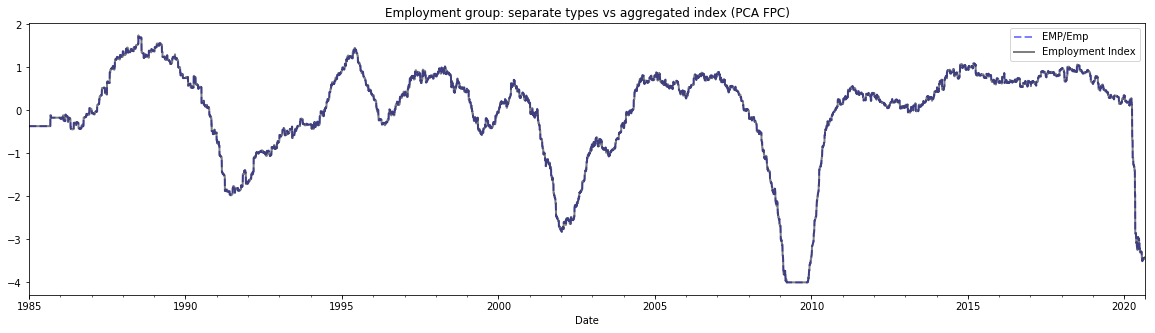

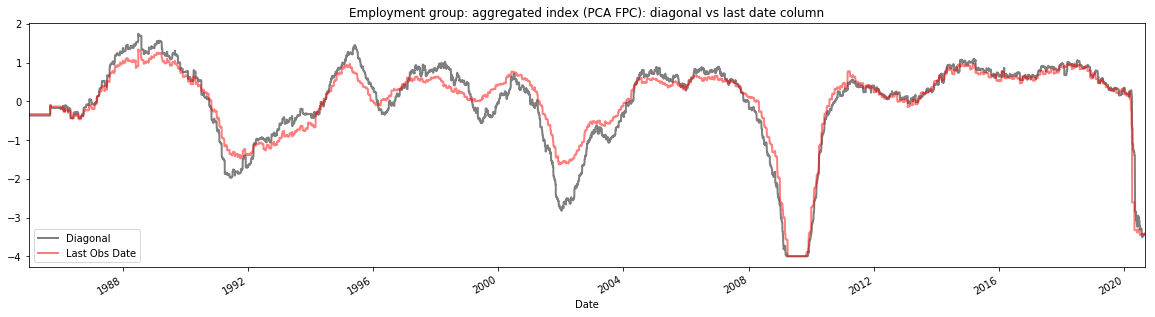

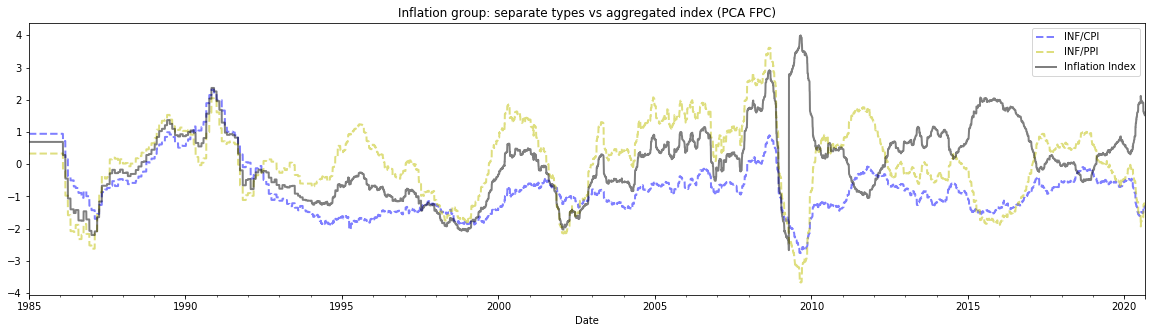

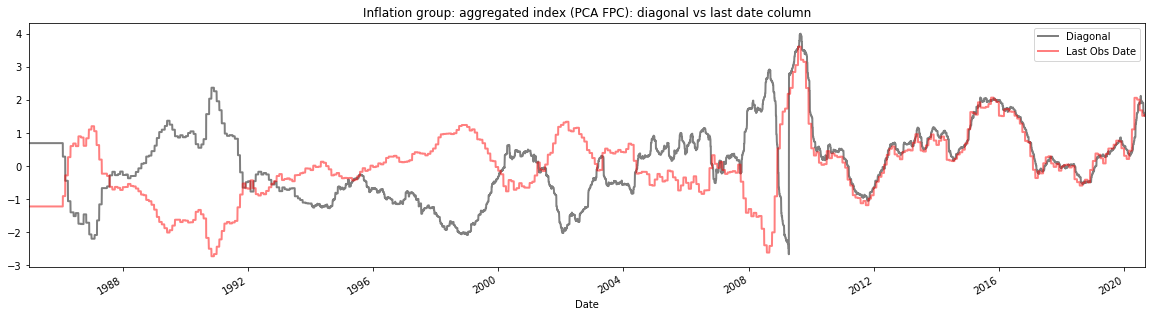

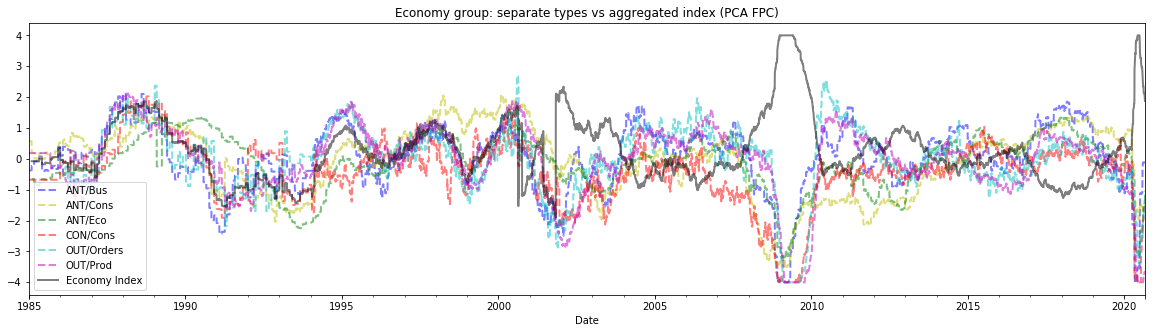

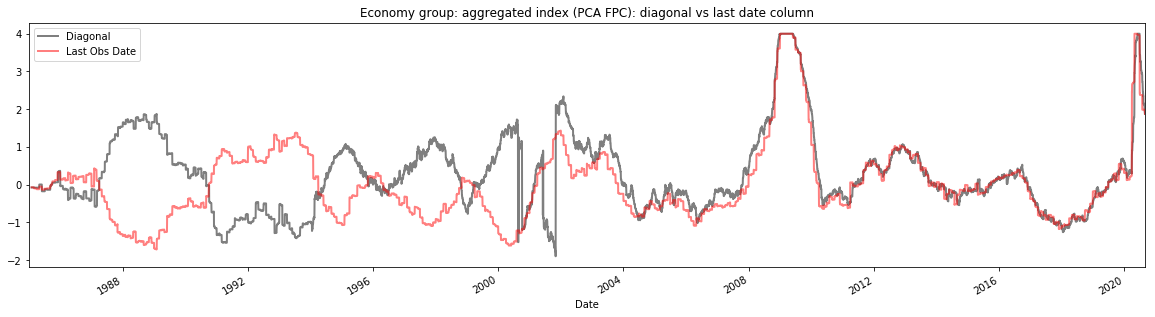

In [8]:
### RUN TO TEST: AGGREGATED DIAGONALS PLOTTING (PCA FPC)

### Visualizing pattern defining:
list_style_pattern = ['b--', 'y--', 'g--', 'r--', 'c--', 'm--', 'k-']
### Loading dates indices:
idx_obs_range = pd.read_hdf(str_path_overall_dates_hdf, key = str_key_obs_dates).index
### Sub type mean diagonals loading:
ser_sub_type_diag = pd.read_hdf(str_path_bb_diag_hdf, key = str_key_diag_sub_z)
### Aggregated diagonals loading:
ser_agg_diag = pd.read_hdf(str_path_bb_diag_hdf, key = str_key_diag_agg_z)
### Aggregation groups looping:
for iter_group in dict_agg_groups:
    ### Aggregated diagonal extracting:
    ser_iter_agg = ser_agg_diag.loc[[iter_group], All].droplevel('Global_Index')
    ser_iter_agg.name = iter_group + ' Index'    
    ### Sub type mean diagonal extracting:
    ser_iter_sub = ser_sub_type_diag.loc[dict_agg_groups[iter_group], All, All]
    df_iter_sub = ser_iter_sub.unstack(['Type_Prime', 'Sub_Type'])
    df_iter_sub.columns = ['/'.join(iter_column) for iter_column in df_iter_sub.columns] 
    ### Diagonals plotting:
    df_iter_agg = df_iter_sub.join(ser_iter_agg, how = 'outer')
    df_iter_agg.index.names = ['Date']    
    list_iter_styles = list_style_pattern[: len(df_iter_agg.columns) - 1] + list_style_pattern[-1 :]
    df_iter_agg.plot(figsize = (20, 5), title = iter_group + ' group: separate types vs aggregated index (PCA FPC)', style = list_iter_styles, linewidth = 2.0, alpha = 0.5)
    ### Last observation date for aggregated index loading:
    ser_iter_last = pd.read_hdf(str_path_global_matrix_hdf, key = str_key_global_matrix, where = '(Global_Index == iter_group) & (Observation_Date == idx_obs_range[-1])')
    ser_iter_last = ser_iter_last.droplevel(['Global_Index', 'Observation_Date'])
    ### Diagonal vs last date plotting:
    df_iter_last = pd.concat([ser_iter_agg, ser_iter_last], axis = 1).ffill()
    df_iter_last.index.names = ['Date']
    df_iter_last.columns = ['Diagonal', 'Last Obs Date']
    df_iter_last.plot(figsize = (20, 5), title = iter_group + ' group: aggregated index (PCA FPC): diagonal vs last date column', 
                      style = ['k-', 'r-'], linewidth = 2.0, alpha = 0.5)

In [52]:
### TEMP

gc.collect()
#df_test = df_iter_matrix.groupby('Observation_Date').apply(single_date_pca)

24254

In [ ]:
### RUN TO RE-EXPORT DATA: SUB TYPES MATRICES AGGREGATION BY SIMPLE MEAN

### Defining time-vector z-scoring procedure:    
def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj):
    ### Check for empty vector (doing nothing):
    if ser_date.count():
        ### Check for non-constant vector:
        if (ser_date.std() > flo_tolerance):
            ### Check for minimal quantity of observations to z-score:
            if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                ### Calculating of z scores:
                ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                bool_to_winsor = True   
                int_iter = 1
                while (bool_to_winsor): 
                    int_iter += 1                
                    ### Value based winsorization:                
                    ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                    ### Recalculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                    ### Checking for boundaries and steps:
                    if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                        bool_to_winsor = False
            else:
                ### Killing values that we can't z-score
                ser_date.loc[All] = np.NaN
        else:
            ### Check for minimal quantity of observations to z-score:
            if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                ### Constant values demeaning:
                ser_date = ser_date - ser_date.mean()
            else:
                ### Killing values that we can't z-score
                ser_date.loc[All] = np.NaN
    ### Memory optimization:
    ser_date = ser_date.astype('float32')
    return ser_date        

### Chunk size defining:
int_chunksize = 10 ** 6   
### Max group name length calculating:
int_max_global_len = max(map(len, dict_agg_groups.keys()))
### Primary Type / Sub Type structure loading preparing:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
ser_sub_type = df_flags_typed[['Type_Prime', 'Sub_Type']].drop_duplicates().sort_values(['Type_Prime', 'Sub_Type']).set_index('Type_Prime').squeeze()
### Previous HDF file deleting:
if os.path.isfile(str_path_mean_matrix_hdf):
    os.remove(str_path_mean_matrix_hdf)
### Looping over aggregation lists:
for iter_group in dict_agg_groups:
    gc.collect() 
    ### First element flag:
    bool_first_element = True
    ### Looping over primary type inside the particular aggregation list:
    for iter_type_prime in dict_agg_groups[iter_group]:
        ### Looping over sub type for the particular primary type:
        for iter_sub_type in ser_sub_type.loc[[iter_type_prime]]:
            print(iter_group, ':' , iter_type_prime, '/', iter_sub_type, 'matrix loading')
            ### Iteration container preparing:
            list_iter_container = []
            ### Sub type matrix loading by looping over chunks:
            for iter_chunk in pd.read_hdf(str_path_sub_matrix_hdf, key = str_key_sub_matrix, chunksize = int_chunksize, 
                                          where = '(Type_Prime == iter_type_prime) & (Sub_Type == iter_sub_type)'):
                list_iter_container.append(iter_chunk)
                del iter_chunk
                gc.collect()        
            ### Sub type matrix constructing:
            print(iter_group, ':', iter_type_prime, '/', iter_sub_type, 'chunks aggregating')
            ser_iter_matrix = pd.concat(list_iter_container, axis = 0).droplevel(['Type_Prime', 'Sub_Type']).sort_index()
            del list_iter_container
            gc.collect()        
            ser_iter_matrix.name = '/'.join([iter_type_prime, iter_sub_type])
            ### Adding sub type data as a column to common group table:
            print(iter_group, ':', iter_type_prime, '/', iter_sub_type, 'adding to group table')            
            if bool_first_element:
                df_iter_matrix = ser_iter_matrix.to_frame()
                bool_first_element = False
            else:
                df_iter_matrix[ser_iter_matrix.name] = ser_iter_matrix.values
            del ser_iter_matrix
            gc.collect()                         
    ### Aggregating by simple mean scoring:
    print(iter_group, ': simple mean scoring')
    ser_iter_mean = df_iter_matrix.groupby('Observation_Date', group_keys = False).apply(lambda df_group: df_group.mean(axis = 1)).sort_index()
    del df_iter_matrix
    gc.collect()
    ### Observation date vectors z-scoring:
    print(iter_group, ': z-scoring')    
    ser_iter_mean_z = ser_iter_mean.groupby('Observation_Date')\
                                   .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years)
    del ser_iter_mean
    gc.collect() 
    ### Adding aggregated data to the file:
    print(iter_group, ': adding to the file')    
    pd.concat([ser_iter_mean_z], keys = [iter_group], names = ['Global_Index'])\
                                    .to_hdf(str_path_mean_matrix_hdf, key = str_key_mean_matrix, format = 'table', complevel = 9, append = True, mode = 'a',
                                            min_itemsize = {'Global_Index': int_max_global_len}) 
    del ser_iter_mean_z
    gc.collect()

In [11]:
### RUN TO RE-EXPORT DATA: Z_SCORED SIMPLE MEAN DIAGONAL CONSTRUCTING:

### Creating container for groups diagonals:
list_groups_diag = []
### Chunk size defining:
int_chunksize = 10 ** 6
### Looping over sub types:
for iter_group in dict_agg_groups:
    ### Iteration container preparing:
    gc.collect()
    list_iter_container = []
    ### Sub type matrix loading:
    print(iter_group, 'loading') 
    for iter_chunk in pd.read_hdf(str_path_mean_matrix_hdf, key = str_key_mean_matrix, chunksize = int_chunksize, 
                                  where = '(Global_Index == iter_group) & (Observation_Date >= date_diag_start)'):
        list_iter_container.append(iter_chunk)
        del iter_chunk
        gc.collect()    
    ### Sub type matrix constructing:
    ser_iter_matrix = pd.concat(list_iter_container, axis = 0).droplevel('Global_Index').sort_index()
    del list_iter_container
    gc.collect()                         
    print(iter_group, 'main diagonal part constructing') 
    ### Extracting unique observation dates for each ticker later than diagonal start date:
    idx_date_list = ser_iter_matrix.index.get_level_values('Observation_Date').unique()
    ### Creating future diagonal vector:
    ser_iter_diag = ser_iter_matrix.groupby('Observation_Date').apply(lambda ser_obs_date: ser_obs_date.dropna()[-1] if (ser_obs_date.count() > 0) else np.NaN)
    ### Checking for data earlier than diagonal start date:
    if (ser_iter_matrix.dropna().loc[All, idx_date_list[0]].index[0] < date_diag_start):
        ### Selecting column to be turned:
        print(iter_group, 'auxiliary diagonal part constructing') 
        ser_iter_to_turn = ser_iter_matrix.loc[ : idx_date_list[0] - pd.offsets.Day(1), [idx_date_list[0]]].droplevel('Observation_Date')
        ### Joining series:
        ser_iter_diag = pd.concat([ser_iter_to_turn, ser_iter_diag], axis = 0).sort_index() 
    ### Reindexation to business daily vector and forward filling:
    ser_iter_diag = ser_iter_diag.ffill().reindex(idx_date_range).ffill()
    ser_iter_diag = ser_iter_diag.astype('float32')
    ### Saving ticker diagonal to the container:
    list_groups_diag.append(pd.concat([ser_iter_diag], keys = [iter_group], names = ['Global_Index']))
    print(iter_group, 'diagonal added to container')
### Container converting and adding to HDF:
ser_mean_type_diag = pd.concat(list_groups_diag, axis = 0)
ser_mean_type_diag.index.set_names(names = 'Data_Date', level = 1, inplace = True)
ser_mean_type_diag.to_hdf(str_path_bb_diag_hdf, key = str_key_diag_mean_z, mode = 'a')

Employment loading
Employment main diagonal part constructing
Employment auxiliary diagonal part constructing
Employment diagonal added to container
Inflation loading
Inflation main diagonal part constructing
Inflation auxiliary diagonal part constructing
Inflation diagonal added to container
Economy loading
Economy main diagonal part constructing
Economy auxiliary diagonal part constructing
Economy diagonal added to container


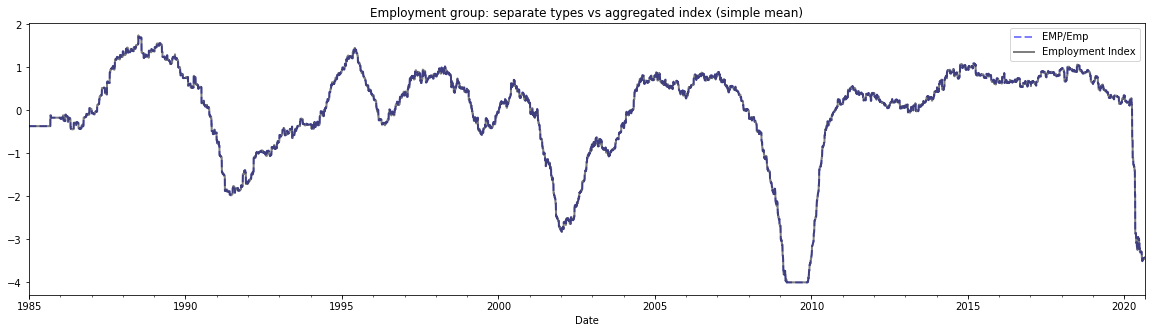

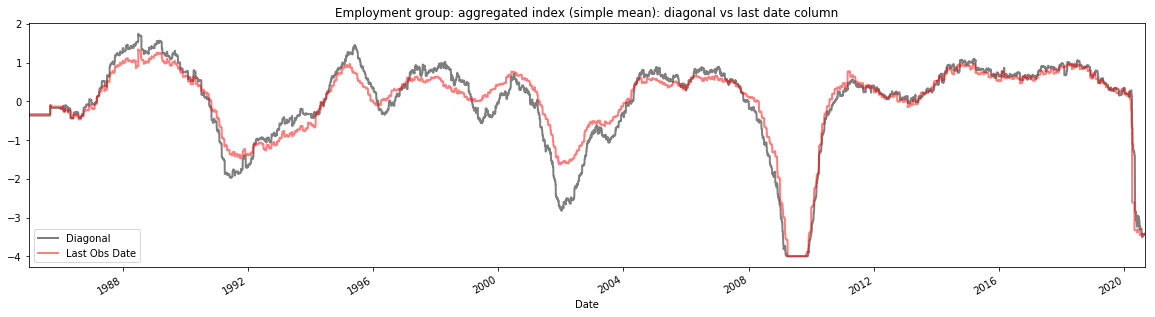

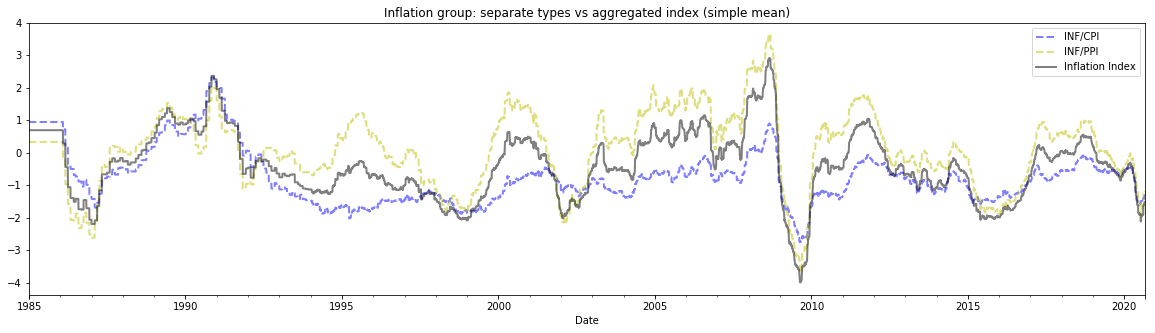

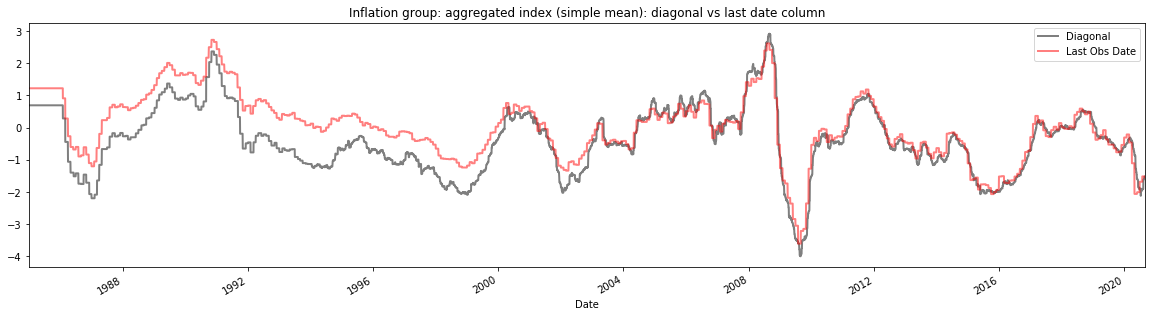

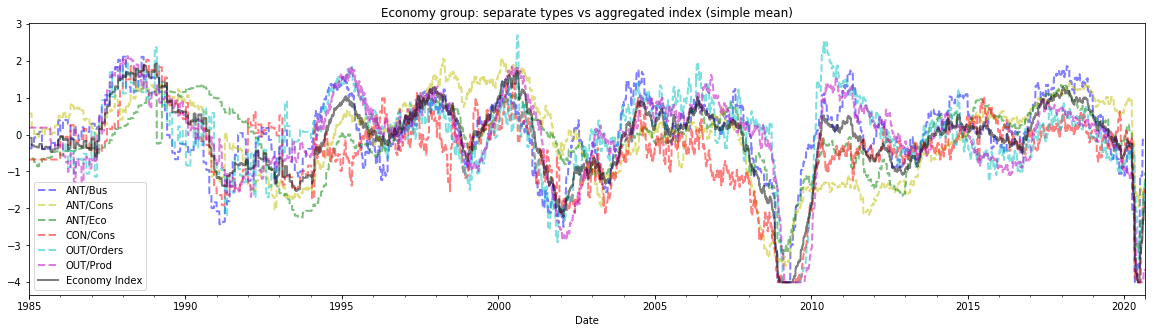

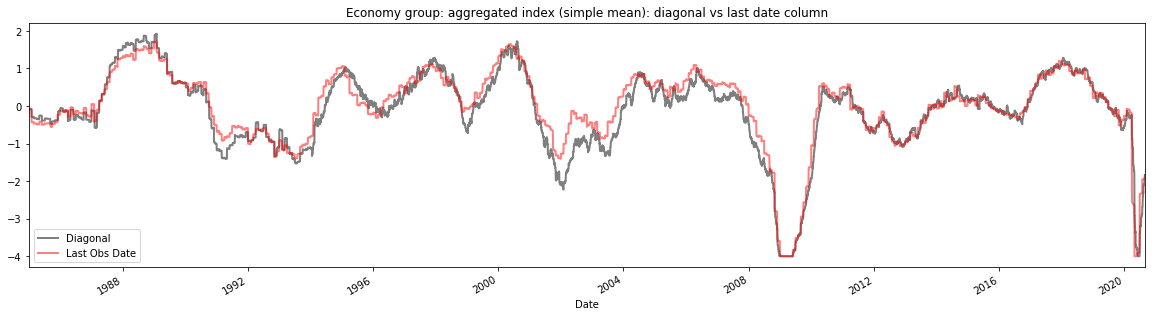

In [10]:
### RUN TO TEST: AGGREGATED DIAGONALS PLOTTING (SIMPLE MEAN)

### Visualizing pattern defining:
list_style_pattern = ['b--', 'y--', 'g--', 'r--', 'c--', 'm--', 'k-']
### Loading dates indices:
idx_obs_range = pd.read_hdf(str_path_overall_dates_hdf, key = str_key_obs_dates).index
### Sub type mean diagonals loading:
ser_sub_type_diag = pd.read_hdf(str_path_bb_diag_hdf, key = str_key_diag_sub_z)
### Aggregated diagonals loading:
ser_agg_diag = pd.read_hdf(str_path_bb_diag_hdf, key = str_key_diag_mean_z)
### Aggregation groups looping:
for iter_group in dict_agg_groups:
    ### Aggregated diagonal extracting:
    ser_iter_agg = ser_agg_diag.loc[[iter_group], All].droplevel('Global_Index')
    ser_iter_agg.name = iter_group + ' Index'    
    ### Sub type mean diagonal extracting:
    ser_iter_sub = ser_sub_type_diag.loc[dict_agg_groups[iter_group], All, All]
    df_iter_sub = ser_iter_sub.unstack(['Type_Prime', 'Sub_Type'])
    df_iter_sub.columns = ['/'.join(iter_column) for iter_column in df_iter_sub.columns] 
    ### Diagonals plotting:
    df_iter_agg = df_iter_sub.join(ser_iter_agg, how = 'outer')
    df_iter_agg.index.names = ['Date']    
    list_iter_styles = list_style_pattern[: len(df_iter_agg.columns) - 1] + list_style_pattern[-1 :]
    df_iter_agg.plot(figsize = (20, 5), title = iter_group + ' group: separate types vs aggregated index (simple mean)', 
                     style = list_iter_styles, linewidth = 2.0, alpha = 0.5)
    ### Last observation date for aggregated index loading:
    ser_iter_last = pd.read_hdf(str_path_mean_matrix_hdf, key = str_key_mean_matrix, where = '(Global_Index == iter_group) & (Observation_Date == idx_obs_range[-1])')
    ser_iter_last = ser_iter_last.droplevel(['Global_Index', 'Observation_Date'])
    ### Diagonal vs last date plotting:
    df_iter_last = pd.concat([ser_iter_agg, ser_iter_last], axis = 1).ffill()
    df_iter_last.index.names = ['Date']
    df_iter_last.columns = ['Diagonal', 'Last Obs Date']
    df_iter_last.plot(figsize = (20, 5), title = iter_group + ' group: aggregated index (simple mean): diagonal vs last date column', 
                      style = ['k-', 'r-'], linewidth = 2.0, alpha = 0.5)

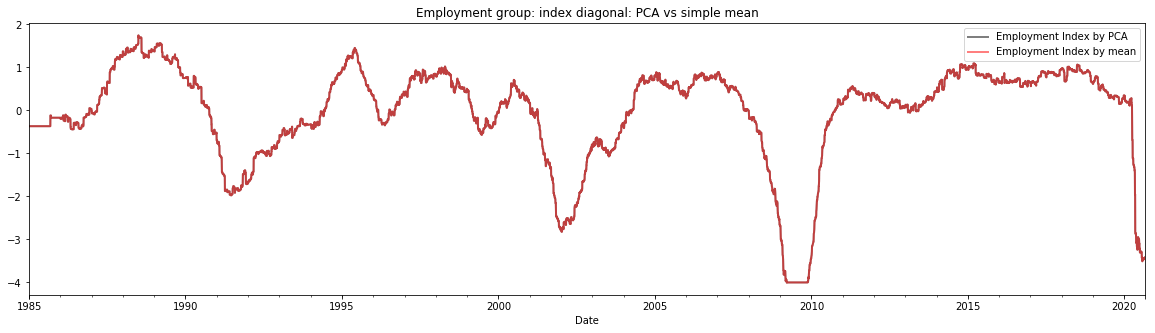

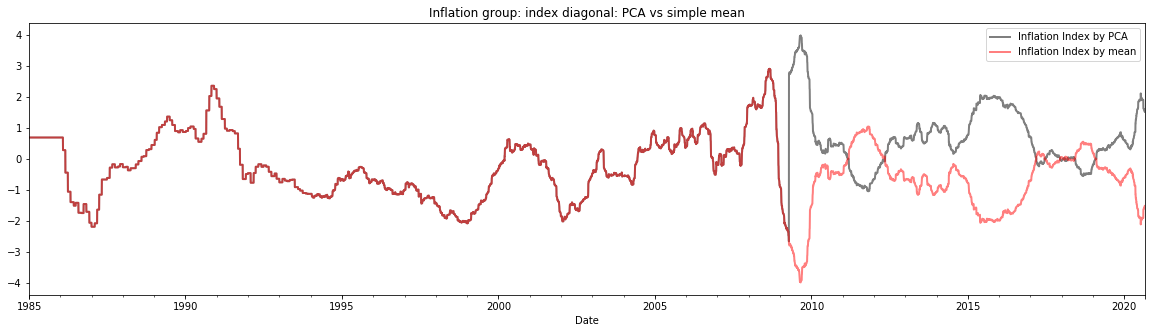

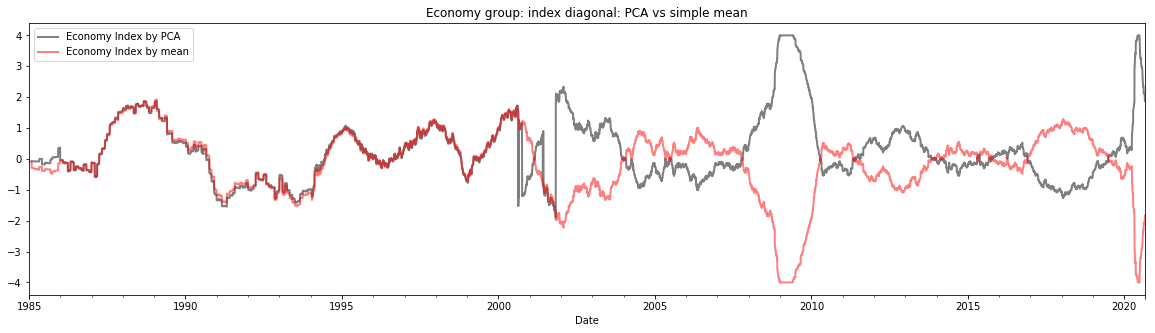

In [11]:
### RUN TO TEST: AGGREGATED DIAGONALS PLOTTING (SIMPLE MEAN VS PCA FPC)

### Visualizing pattern defining:
list_style_pattern = ['b--', 'y--', 'g--', 'r--', 'c--', 'm--', 'k-']
### Aggregated diagonals loading:
ser_agg_diag = pd.read_hdf(str_path_bb_diag_hdf, key = str_key_diag_agg_z)
ser_mean_diag = pd.read_hdf(str_path_bb_diag_hdf, key = str_key_diag_mean_z)
### Aggregation groups looping:
for iter_group in dict_agg_groups:
    ### Aggregated diagonal extracting:
    ser_iter_agg = ser_agg_diag.loc[[iter_group], All].droplevel('Global_Index')
    ser_iter_agg.name = iter_group + ' Index by PCA'    
    ser_iter_mean = ser_mean_diag.loc[[iter_group], All].droplevel('Global_Index')
    ser_iter_mean.name = iter_group + ' Index by mean'    
    ### Diagonal vs last date plotting:
    df_iter_compare = pd.concat([ser_iter_agg, ser_iter_mean], axis = 1).ffill()
    df_iter_compare.index.names = ['Date']
    df_iter_compare.plot(figsize = (20, 5), title = iter_group + ' group: index diagonal: PCA vs simple mean', style = ['k-', 'r-'], linewidth = 2.0, alpha = 0.5)

In [15]:
### TEMP

gc.collect()

14934